# 0. Gameplan

Let's make a pandas dataframe with columns.

Metadata
1. path
2. fps
2. position
3. object
5. t_duration
4. t_start
5. t_end
6. f_start
7. f_end
8. n_lasers

Now the actual data should have the columns:
1. time (30_000)
2. shifts_raw (100,30_000,2)
3. shifts (100,30_000,2)
4. fft freq (100,11_000,2)
5. fft val (100,11_000,2)
9. fft val phase-synced (100,11_000,2)
6. mode fft freq (100,5,2)
8. mode time (100,5,2)
7. mode fft val (100,5,2)
10. mode fft val phase-synced (100,5,2)
 
Visualizations:
1. x,y shifts over all lasers over time
2. FFT magnitude averaged over lasers, time
3. modes
    1. FFT magnitude
    2. x,y shifts
    3. surface reconstruction
3. Dimension Reduction:
    1. PCA 2D,3D + cumulative PCA variance + PCA pairwise distance
    2. Diffusion Map 2D,3D + cumulative Diffusion Map variance + Diffusion Map pairwise distance

compare 2D PCA of
1. (shifts, shifts_raw)
2. (fft val magnitude, fft val angle, fft val magnitude+angle)
3. (all frequencies, just mode frequencies)
4. (not phase-synced, phase-synced)
5. (duplicates, no duplicates)

The ideal results is that the best representation comes from doing PCA on:
1. phase-synced
2. modes
3. with magnitude+amplitude
4. and duplicates

I think I should use polars, hf_dataset?

Some metrics!
1. Measure the variance from 3 PCA
2. Measure the number of PCAs needed to reach 90% variance
3. Measure for what number of PCA the duplicates are closest to each other

Plot the number of modes VS the above metrics!

# 1. Setup

In [1]:
# reload all modules every time before executing
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
from pathlib import Path
import sys, types

import numpy as np

In [3]:
# Patch for pickle compatibility
if 'recover_core_lib' not in sys.modules:
    print('adding `recover_core_lib` to sys')
    fake = types.ModuleType('recover_core_lib')
    fake.compute_CAM2_translations_v3_cupy = lambda *a, **k: None
    sys.modules['recover_core_lib'] = fake

adding `recover_core_lib` to sys


In [4]:
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

In [5]:
# this automatically displays all plots, even if we don't have plt.show()
# this also makes all plots interactive
%matplotlib widget

# 2. Load Data

In [6]:
from collections import defaultdict

In [7]:
BASE_DIR = Path('../data/experiment_01/')
exp_dirs = sorted([d for d in BASE_DIR.iterdir() if d.is_dir()])
print(f'Found {len(exp_dirs)} experiment directories')
exp_dirs

Found 8 experiment directories


[PosixPath('../data/experiment_01/cube_pos1_29_12_Time_19_16_40'),
 PosixPath('../data/experiment_01/cube_pos2_29_12_Time_19_03_39'),
 PosixPath('../data/experiment_01/cube_pos2_29_12_Time_19_13_50'),
 PosixPath('../data/experiment_01/cube_pos3_29_12_Time_19_27_21'),
 PosixPath('../data/experiment_01/cube_pos3_29_12_Time_19_29_43'),
 PosixPath('../data/experiment_01/cube_pos4_29_12_Time_19_24_21'),
 PosixPath('../data/experiment_01/cube_pos5_29_12_Time_19_22_12'),
 PosixPath('../data/experiment_01/cube_pos6_29_12_Time_19_20_07')]

In [8]:
def load_data(exp_dirs) -> dict:
    """Load recovery and metadata from an experiment directory."""

    duplicate_idx_map = defaultdict(int)
    data = {}

    for exp_dir in exp_dirs:
        recovery = np.load(exp_dir / 'RECOVERY.npz', allow_pickle=True)
        fs = recovery['run_opt'].item()['cam_params']['camera_FPS'] # use frames-per-second as sampling-frequency

        object = str(exp_dir).split('/')[-1].split('_')[0]
        position = int(str(exp_dir).split('/')[-1].split('_')[1][3:])

        key = (object, position)
        duplicate_idx_map[key] += 1
        duplicate_idx = duplicate_idx_map[key]

        name = f'{object}-pos{position}-{duplicate_idx:02}'

        d = {
            'object': object,
            'position': position,
            'duplicate_idx': duplicate_idx,
            'fs': fs,
            'path': exp_dir,
            'raw_shifts': recovery['all_shifts'],
        }
        data[name] = d
    return data

In [9]:
data = load_data(exp_dirs)

In [10]:
len(data)

8

In [11]:
data.keys()

dict_keys(['cube-pos1-01', 'cube-pos2-01', 'cube-pos2-02', 'cube-pos3-01', 'cube-pos3-02', 'cube-pos4-01', 'cube-pos5-01', 'cube-pos6-01'])

In [12]:
for name, d in data.items():
    d['timesteps'] = np.arange(d['raw_shifts'].shape[1]) / d['fs']

d.keys()

dict_keys(['object', 'position', 'duplicate_idx', 'fs', 'path', 'raw_shifts', 'timesteps'])

In [13]:
name = 'cube-pos1-01'
raw_shifts = data[name]['raw_shifts']
timesteps = data[name]['timesteps']
fs = data[name]['fs']

In [14]:
raw_shifts.shape

(100, 30000, 2)

In [15]:
timesteps

array([0.0000e+00, 2.0000e-04, 4.0000e-04, ..., 5.9994e+00, 5.9996e+00,
       5.9998e+00], shape=(30000,))

In [16]:
fs

5000

# 2.5 PCA Analysis

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from scipy.spatial.distance import pdist, squareform
from matplotlib.patches import Patch

# --- Global Style Configuration ---
plt.rcParams.update({'font.size': 9, 'axes.spines.top': False, 'axes.spines.right': False})
COLORS = plt.cm.Set2.colors
SCATTER_KWARGS = dict(s=120, edgecolor='white', linewidth=1.2, alpha=0.9)

def prepare_pca_data(data, x_key, y_key='position'):
    """Extracts features and labels using concise list comprehensions."""
    def process_x(val):
        # Convert complex FFT to magnitude + phase, then flatten
        if 'fft' in x_key:
            return np.hstack([np.abs(val), np.angle(val)]).flatten()
        return val.flatten()

    X = np.vstack([process_x(d[x_key]) for d in data.values()])
    y = np.array([d[y_key] for d in data.values()])
    return X, y

def run_pca(X, n_components=8, normalize=True):
    """Standardizes and runs PCA, returning the projection and the model."""
    if normalize:
        X = StandardScaler().fit_transform(X)
    pca = PCA(n_components=n_components, random_state=RANDOM_SEED)
    return pca.fit_transform(X), pca

def _get_color_map(y):
    """Utility to map unique labels to the Set2 color palette."""
    unique_y = np.unique(y)
    return {val: COLORS[i % len(COLORS)] for i, val in enumerate(unique_y)}

def plot_pca_projections(X_pca, y, var_pct, title_prefix=""):
    """Creates a beautiful 2D and 3D projection side-by-side."""
    fig = plt.figure(figsize=(10, 5))
    c_map = _get_color_map(y)
    colors = [c_map[val] for val in y]

    # 2D Projection
    ax1 = fig.add_subplot(121)
    ax1.scatter(X_pca[:, 0], X_pca[:, 1], c=colors, **SCATTER_KWARGS)
    for i, label in enumerate(y):
        ax1.annotate(int(label), (X_pca[i, 0], X_pca[i, 1]), fontweight='bold', va='bottom')

    ax1.set(title='PCA: 2D Projection', xlabel=f'PC1 ({var_pct[0]:.1f}%)', ylabel=f'PC2 ({var_pct[1]:.1f}%)')
    ax1.grid(True, alpha=0.2)

    # 3D Projection
    ax2 = fig.add_subplot(122, projection='3d')
    ax2.scatter(X_pca[:, 0], X_pca[:, 1], X_pca[:, 2], c=colors, **SCATTER_KWARGS)
    for i, label in enumerate(y):
        ax2.text(X_pca[i, 0], X_pca[i, 1], X_pca[i, 2], f" {int(label)}", fontweight='bold')

    ax2.set(title='PCA: 3D Projection', xlabel='PC1', ylabel='PC2', zlabel='PC3')
    # Clean up 3D background
    ax2.xaxis.pane.fill = ax2.yaxis.pane.fill = ax2.zaxis.pane.fill = False
    fig.suptitle(title_prefix+'Visualize PCA', fontsize=14, fontweight='bold')

    plt.tight_layout()
    return fig

def plot_pairwise_distances(X_pca, y, var_pct, title_prefix=""):
    """Visualizes distance matrices for increasing PC counts with position labels and legend."""
    n = len(y)
    fig, axes = plt.subplots(2, 4, figsize=(14, 7))

    for pc_idx, ax in enumerate(axes.flat):
        # Distance matrix for the first 'pc_idx + 1' components
        dists = squareform(pdist(X_pca[:, :pc_idx + 1]))

        # Logic: Find if the duplicate (same 'y' value) is the nearest neighbor
        # Also compute score for same-position pairs that are mutually closest
        status_matrix = np.zeros((n, n))
        n_constraints = 0
        n_correct = 0

        for i in range(n):
            for j in range(i + 1, n):
                if y[i] == y[j]:
                    n_constraints += 1
                    # Check if j is the closest to i (excluding i itself)
                    dist_from_i = dists[i].copy()
                    dist_from_i[i] = np.inf
                    closest_to_i = np.argmin(dist_from_i)

                    # Check if i is the closest to j (excluding j itself)
                    dist_from_j = dists[j].copy()
                    dist_from_j[j] = np.inf
                    closest_to_j = np.argmin(dist_from_j)

                    # Both must be mutually closest
                    if closest_to_i == j and closest_to_j == i:
                        status_matrix[i, j] = 1
                        status_matrix[j, i] = 1
                        n_correct += 1
                    else:
                        status_matrix[i, j] = -1
                        status_matrix[j, i] = -1

        score = n_correct / n_constraints if n_constraints > 0 else 1.0

        # Plot with colored cells based on status
        for i in range(n):
            for j in range(n):
                if i == j:
                    color, alpha = 'white', 1.0
                elif status_matrix[i, j] == 1:
                    color, alpha = 'green', 0.6
                elif status_matrix[i, j] == -1:
                    color, alpha = 'red', 0.6
                else:
                    color, alpha = 'gray', 0.3

                rect = plt.Rectangle((j - 0.5, i - 0.5), 1, 1,
                                      facecolor=color, alpha=alpha, edgecolor='black', linewidth=0.5)
                ax.add_patch(rect)

                text_color = 'white' if status_matrix[i, j] != 0 else 'black'
                ax.text(j, i, f'{dists[i, j]:.0f}',
                       ha='center', va='center', color=text_color, fontsize=6, fontweight='bold')

        # Set position labels on axes
        ax.set_xticks(range(n))
        ax.set_yticks(range(n))
        ax.set_xticklabels([int(pos) for pos in y], fontsize=7)
        ax.set_yticklabels([int(pos) for pos in y], fontsize=7)
        ax.set_xlabel('Position', fontsize=8)
        ax.set_ylabel('Position', fontsize=8)
        ax.set_title(f'{pc_idx+1} PC{"s" if pc_idx > 0 else ""} ({var_pct[:pc_idx+1].sum():.0f}%)\nScore: {score:.0%}', fontweight='bold', fontsize=9)
        ax.set_xlim(-0.5, n - 0.5)
        ax.set_ylim(n - 0.5, -0.5)

    # Add legend
    legend_elements = [
        Patch(facecolor='green', alpha=0.6, edgecolor='black', label='Same-pos: mutually closest'),
        Patch(facecolor='red', alpha=0.6, edgecolor='black', label='Same-pos: NOT mutually closest'),
        Patch(facecolor='gray', alpha=0.3, edgecolor='black', label='Different positions')
    ]
    fig.legend(handles=legend_elements, loc='upper right', bbox_to_anchor=(0.99, 0.99), fontsize=8)

    fig.suptitle(title_prefix+'Pairwise Distance by PC\n(Same-position samples should be mutually closest)', fontsize=14, fontweight='bold')
    plt.tight_layout()
    return fig

def plot_variance_explained(pca, title_prefix=""):
    """Standardized bar chart for explained variance."""
    var = pca.explained_variance_ratio_
    cum_var = np.cumsum(var)
    x = np.arange(1, len(var) + 1)

    fig, ax = plt.subplots(figsize=(10, 5))

    # Bars with value labels
    bars = ax.bar(x, var, color=COLORS[0], alpha=0.6, label='Individual')
    for bar in bars:
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height(),
                f'{bar.get_height():.1%}', ha='center', va='bottom', fontweight='bold')

    # Cumulative line
    ax.plot(x, cum_var, 'o-', color=COLORS[1], linewidth=2, label='Cumulative')
    ax.axhline(0.9, color='tomato', linestyle='--', alpha=0.6, label='90% Threshold')

    ax.set(xlabel='Component', ylabel='% Variance', ylim=(0, 1.1), xticks=x)
    ax.legend(frameon=False)
    fig.suptitle(title_prefix+'Cumulative Explained Variance', fontsize=14, fontweight='bold')

    return fig

def run_all_pca(data, x_key, title_prefix="", n_components=8):
    X, y = prepare_pca_data(data, x_key)
    X_pca, pca = run_pca(X, n_components)
    var_pct = pca.explained_variance_ratio_ * 100
    fig_projections = plot_pca_projections(X_pca, y, var_pct, title_prefix)
    fig_distances   = plot_pairwise_distances(X_pca, y, var_pct, title_prefix)
    fig_variance    = plot_variance_explained(pca, title_prefix)
    return [X_pca, pca], [fig_projections, fig_distances, fig_variance]

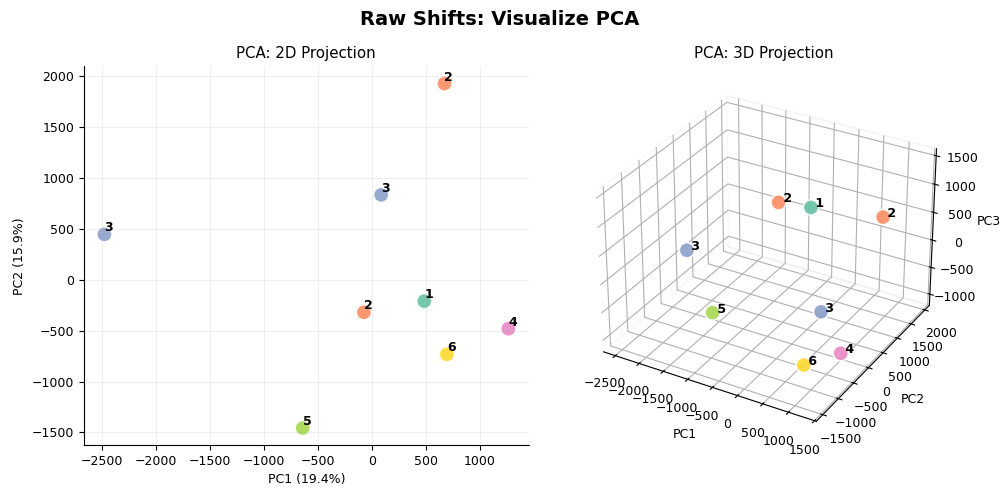

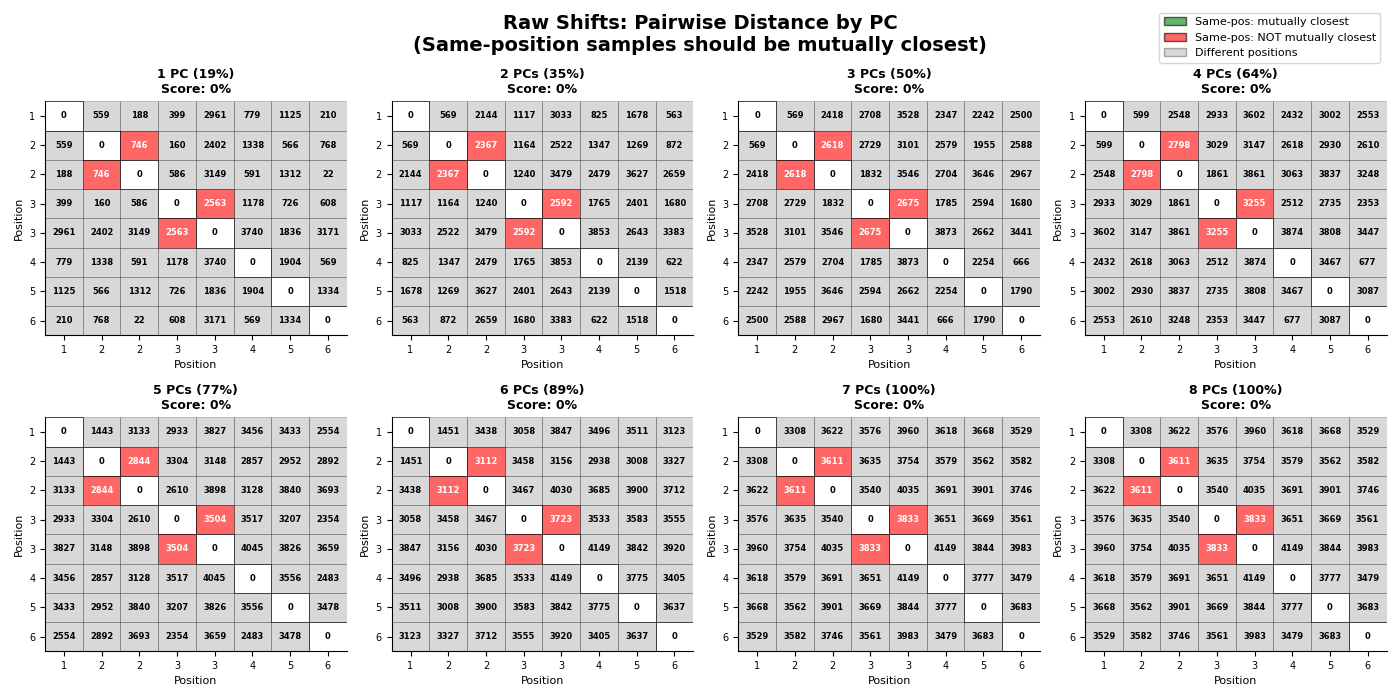

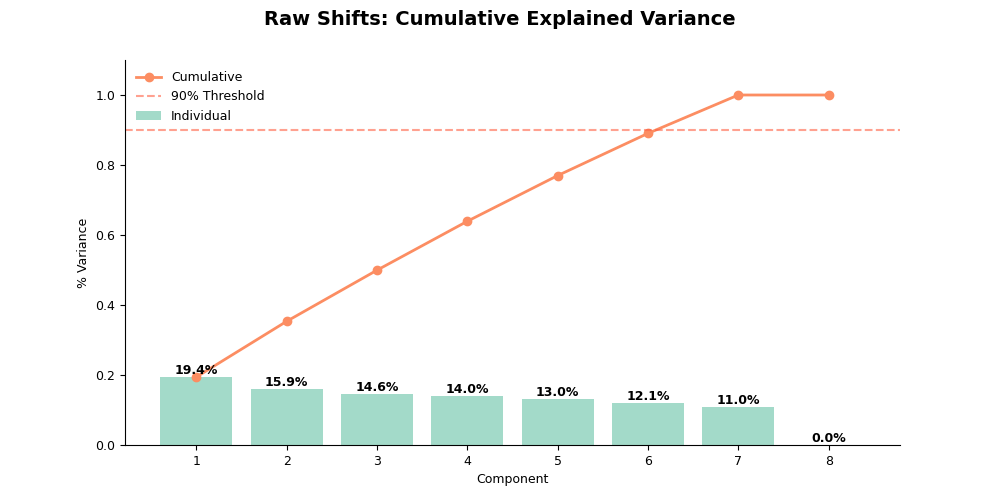

In [18]:
title_prefix = "Raw Shifts: "
_ = run_all_pca(data, 'raw_shifts', "Raw Shifts: ")

# 3. Compute FFT

In [19]:
MIN_FREQ, MAX_FREQ = 50, 2_000

In [20]:
def run_fft(shifts, fs, min_freq=None, max_freq=None):
    # compute fft values and frequencies
    fft_val = np.fft.rfft(shifts, axis=1)
    n_samples = shifts.shape[1]
    freq = np.fft.rfftfreq(n_samples, d=1.0/fs)

    # crop the frequency
    if min_freq is not None and max_freq is not None:
        mask = (freq >= min_freq) & (freq <= max_freq)
        fft_val, freq = fft_val[:, mask, :], freq[mask]
    return fft_val, freq

In [21]:
for name, d in data.items():
    fft_val_raw, freq_raw = run_fft(d['raw_shifts'], d['fs'], MIN_FREQ, MAX_FREQ)
    d['fft_val_raw'], d['freq_raw'] = fft_val_raw, freq_raw

In [22]:
fft_val_raw.shape

(100, 11701, 2)

In [23]:
freq_raw.shape

(11701,)

We have ~11k frequencies when we crop the frequncies to be between 50hz and 2_000 hz.

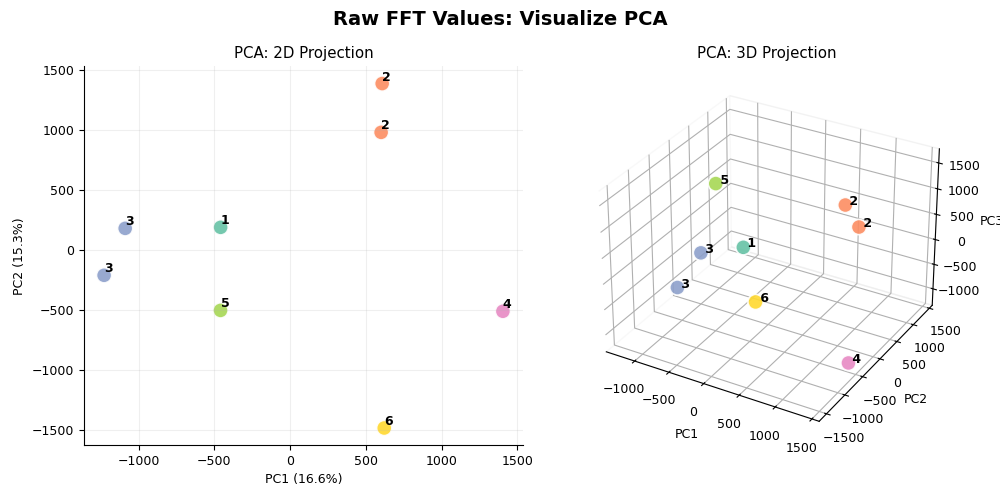

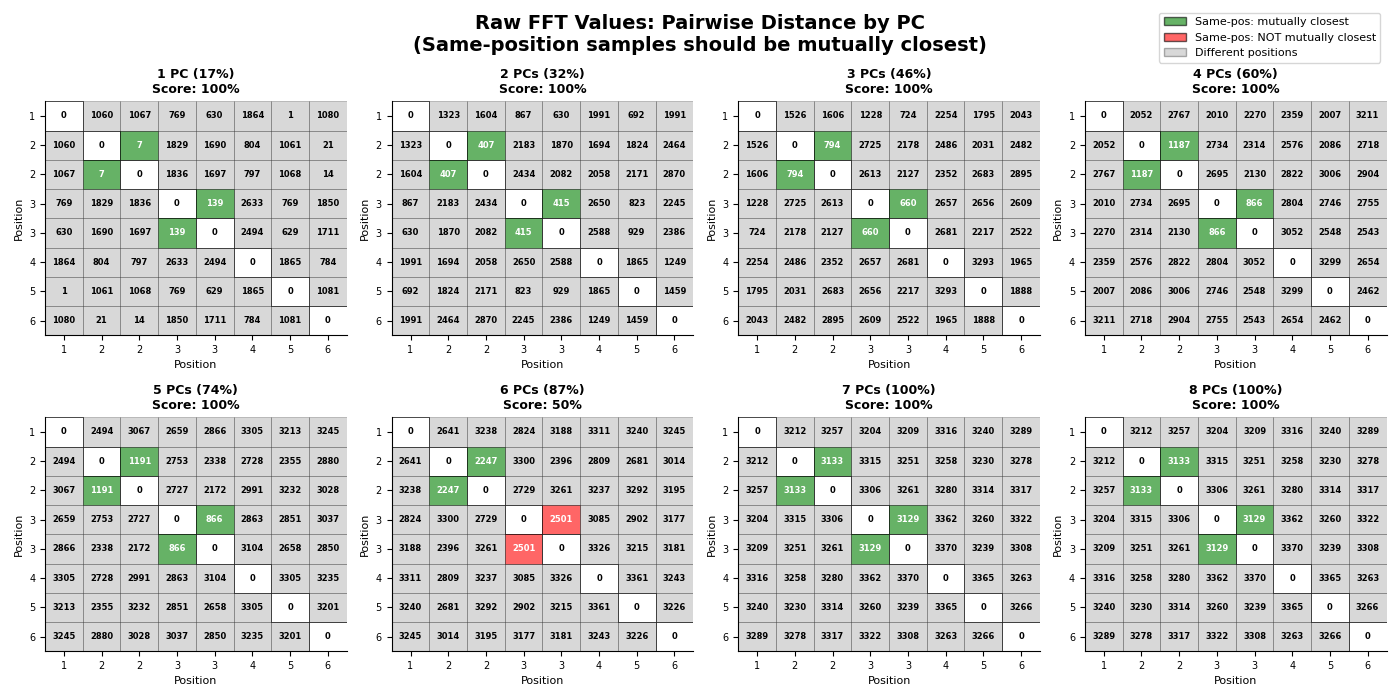

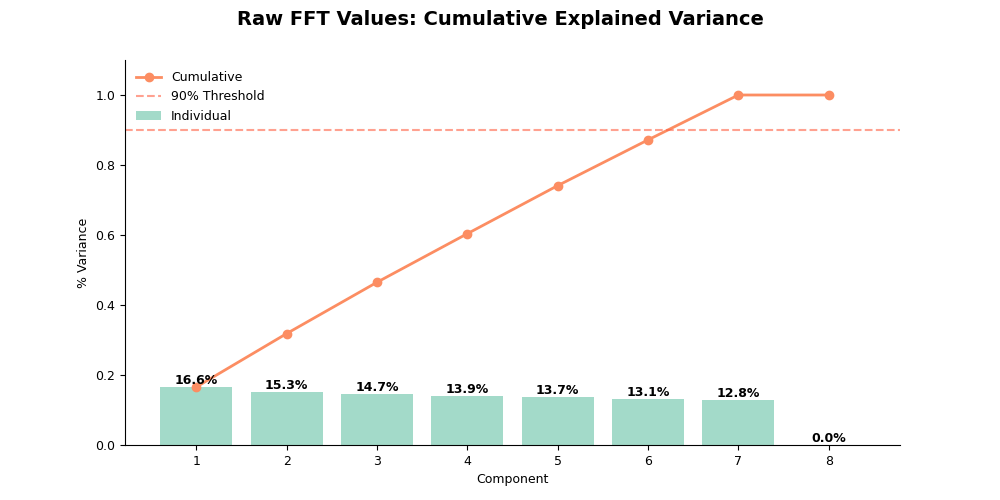

In [24]:
_ = run_all_pca(data, 'fft_val_raw', "Raw FFT Values: ")

# 4. Clean Data

In [25]:
import matplotlib.pyplot as plt
from scipy.signal import butter, sosfiltfilt

In [26]:
def bandpass_filter(shifts, fs, lowcut=50, highcut=None, order=5):
    """Removes frequencies outside of [lowcut, highcut].
    sosfiltfilt applies the filter forward and backward, giving zero phase distortion."""
    if highcut is None: highcut = fs / 2 - 10  # Slightly below Nyquist frequency

    n_lasers, _, n_coords = shifts.shape
    filtered_shifts = np.empty_like(shifts)

    for i in range(n_lasers):
        for j in range(n_coords):
            sos = butter(order, [lowcut, highcut], fs=fs, btype='band', output='sos')
            filtered_shifts[i, :, j] = sosfiltfilt(sos, shifts[i, :, j])
    return filtered_shifts

In [27]:
def hann_window(shifts):
    window = np.hanning(shifts.shape[1])
    return shifts * window[:, np.newaxis]

In [80]:
def fft_magnitude_mean(fft_vals):
    """Compute fft magnitude and average it over all the lasers and x,y coordinates"""
    assert len(fft_vals.shape) == 3
    return np.abs(fft_vals).mean(axis=(0,2)) # average over all lasers (dim 0), x/y coordinates (dim 2)

In [81]:
def fft_magnitude_std(fft_vals):
    """Compute fft magnitude and average it over all the lasers and x,y coordinates"""
    assert len(fft_vals.shape) == 3
    return np.abs(fft_vals).std(axis=(0,2)) # average over all lasers (dim 0), x/y coordinates (dim 2)

In [30]:
def plot_clean_data(shifts, fs):
    # fft for raw signal
    fft_vals, freq = run_fft(shifts, fs)

    # fft for bandpass filter
    bp_shifts = bandpass_filter(shifts, fs)
    bp_fft_vals, bp_freq = run_fft(bp_shifts, fs)

    # fft for bandpass filter + hann window
    wd_shifts = hann_window(bp_shifts)
    wd_fft_vals, wd_freq = run_fft(wd_shifts, fs)

    fig, ax = plt.subplots(figsize=(10, 4))
    ax.plot(freq, fft_magnitude_mean(fft_vals), label='raw')
    ax.plot(bp_freq, fft_magnitude_mean(bp_fft_vals), label='bandpass filter')
    ax.plot(wd_freq, fft_magnitude_mean(wd_fft_vals), label='bandpass filter + hann window')
    ax.set(xlim=(45, 150), ylim=(0, 200), xlabel='Frequency (Hz)', ylabel='Mean FFT Magnitude')
    ax.legend()
    fig.suptitle('Clean the Data')
    return fig

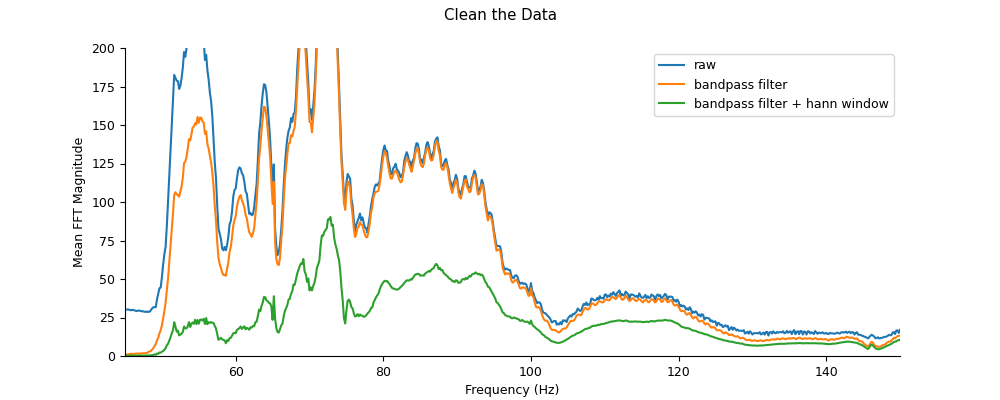

In [31]:
fig = plot_clean_data(raw_shifts, fs)

The fft vals looks much cleaner with bandpass filter + hann window. Let's define a function to clean the shifts and compute the fft on this cleaned data

In [32]:
def clean_shifts(shifts, fs):
    shifts_bp = bandpass_filter(shifts, fs)
    shifts_wd = hann_window(shifts_bp)
    return shifts_wd

In [33]:
for name, d in data.items():
    d['shifts'] = clean_shifts(d['raw_shifts'], d['fs'])
    fft_val, freq = run_fft(d['shifts'], d['fs'], MIN_FREQ, MAX_FREQ)
    d['fft_val'], d['freq'] = fft_val, freq

In [34]:
d.keys()

dict_keys(['object', 'position', 'duplicate_idx', 'fs', 'path', 'raw_shifts', 'timesteps', 'fft_val_raw', 'freq_raw', 'shifts', 'fft_val', 'freq'])

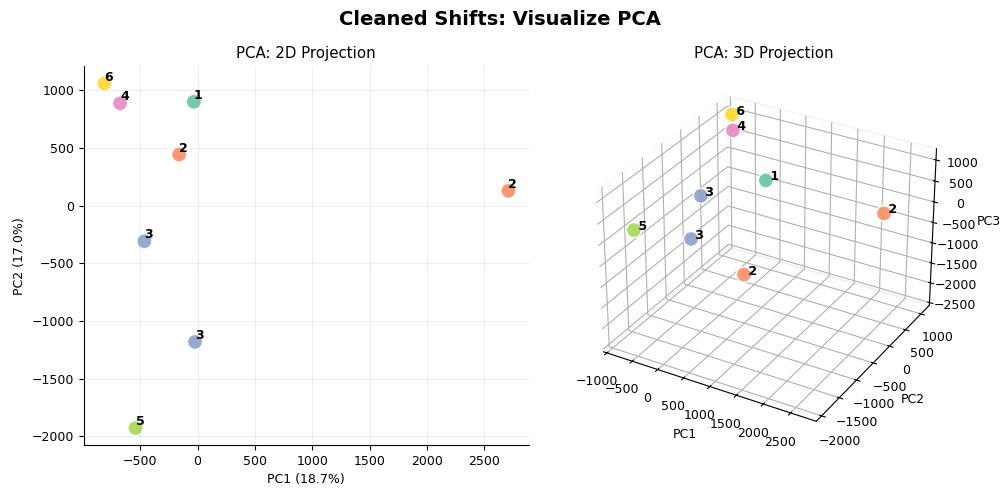

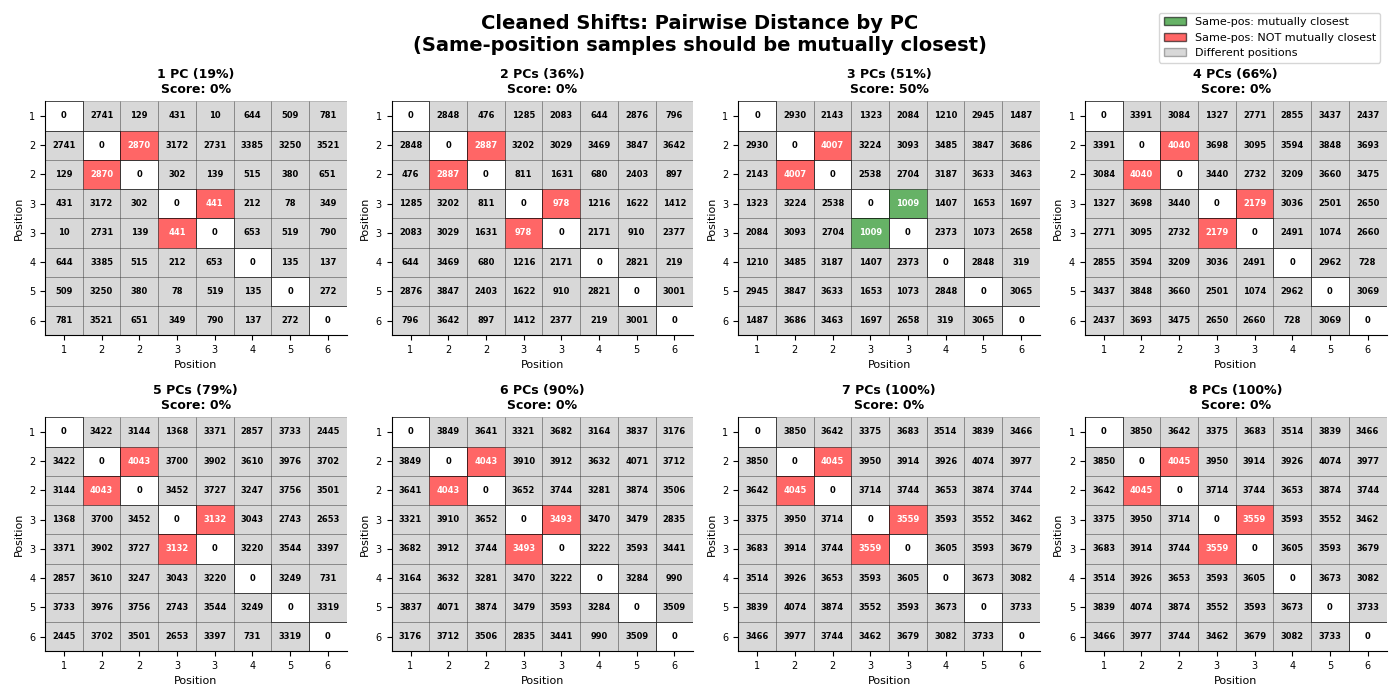

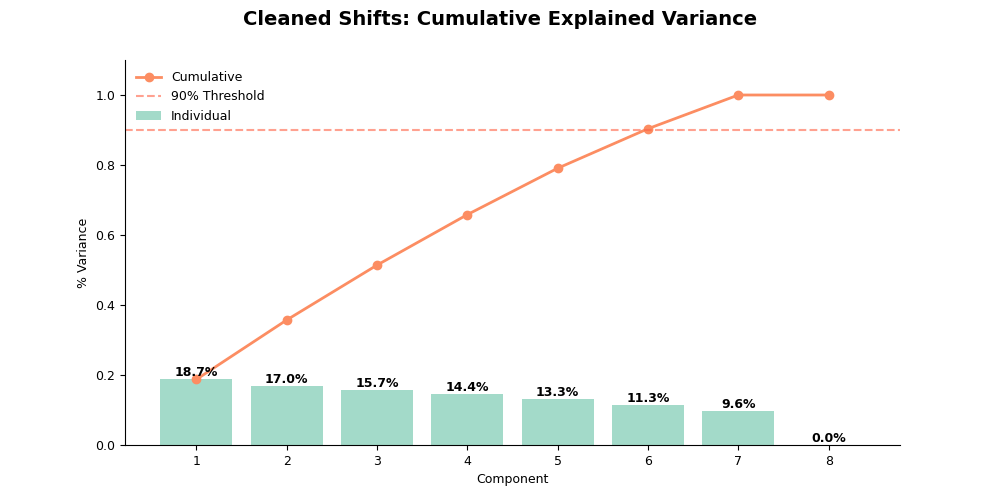

In [35]:
_ = run_all_pca(data, 'shifts', "Cleaned Shifts: ")

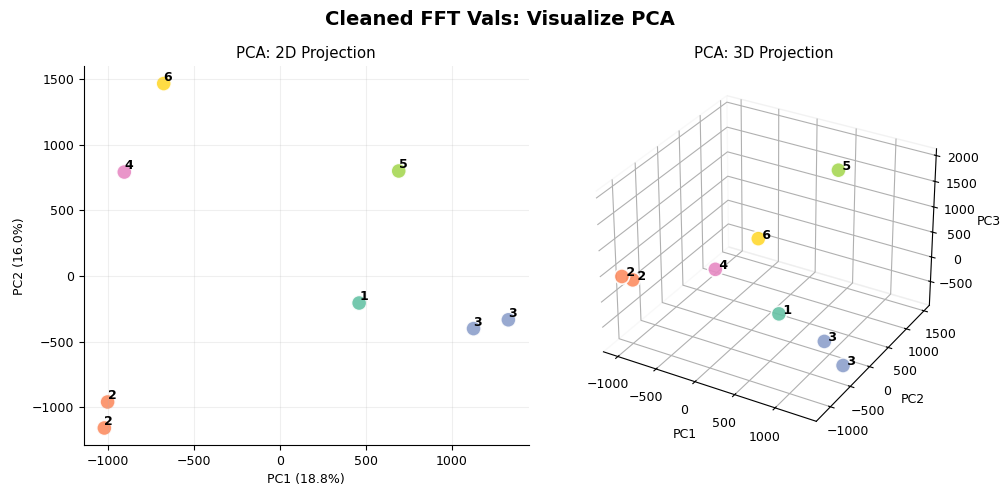

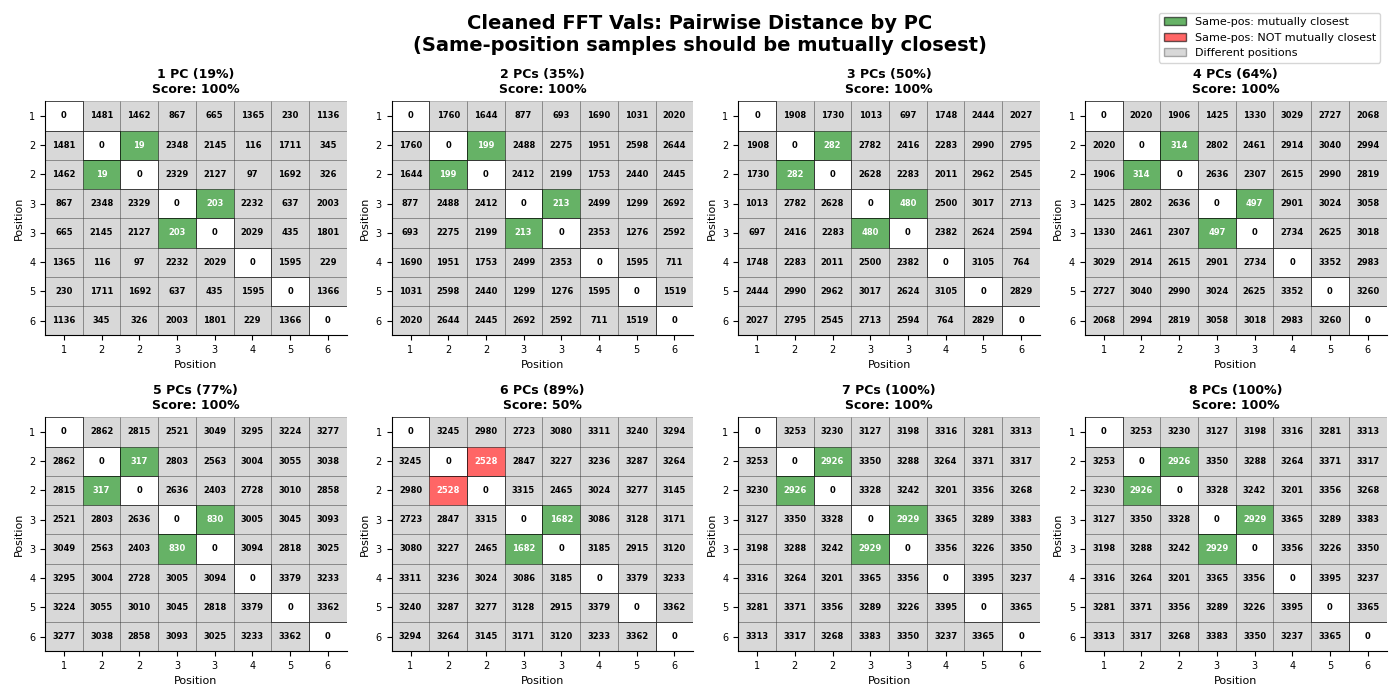

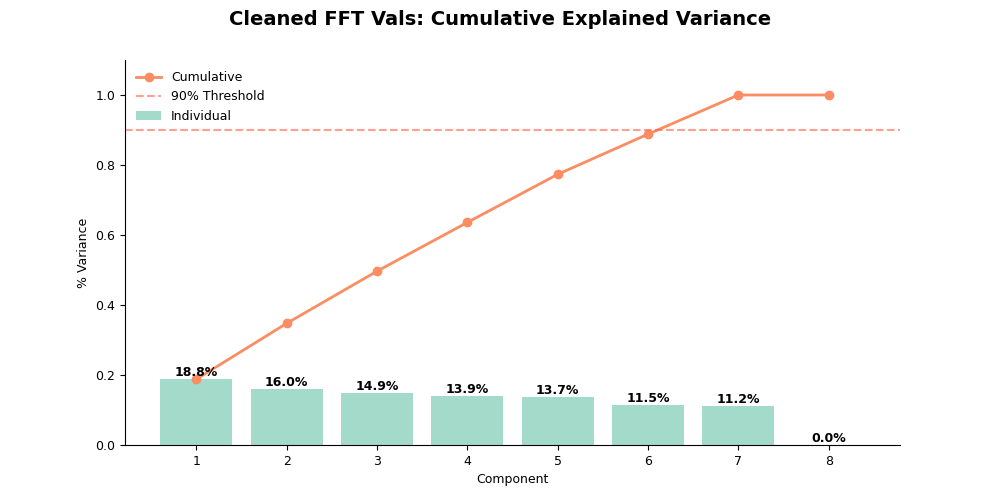

In [36]:
_ = run_all_pca(data, 'fft_val', "Cleaned FFT Vals: ")

# 5. Sync Phases

In [37]:
d['shifts'].shape

(100, 30000, 2)

Currently our shift data is "out of sync". Specifically, different lasers may have different phases, making it hard to compare one laser to another. Moreover, different experiments each with different box-positions might have global phase from timing jitter, reference clock drift, and other hardware side effects. We want to normalize the phase so that every laser is aligned, removing global phase. This mak

This makes it difficult to compare signals across different box-positions and given the same box-position, across different laser positions.


Let's sync the frequencies. This means that for each frequency, we will normalize all lasers and x/y coordinates. This allows us to compare lasers to each other.

Laser `laser_idx`, coordinate `xy_idx` has zero phase. All other lasers’ FFTs are expressed relative to that reference. This is helpful because
1. removes unobservable global phase from timing jitter, reference clock drift, 
2. with global phase removed, phase differences across the 10×10 laser grid become meaningful. you can now see wave propagation, standing modes
3. This makes PCA more meanignful


In [38]:
def sync_phases(fft_vals, laser_idx=0, xy_idx=0, eps=1e-12):
    fft_vals_synced = fft_vals.copy()             # copy
    ref = fft_vals[laser_idx, :, xy_idx]          # shape (freq,)
    phase = np.conj(ref) / (np.abs(ref) + eps)    # unit complex
    fft_vals_synced *= phase[None, :, None]       # broadcast over lasers and xy
    return fft_vals_synced

In [ ]:
# 

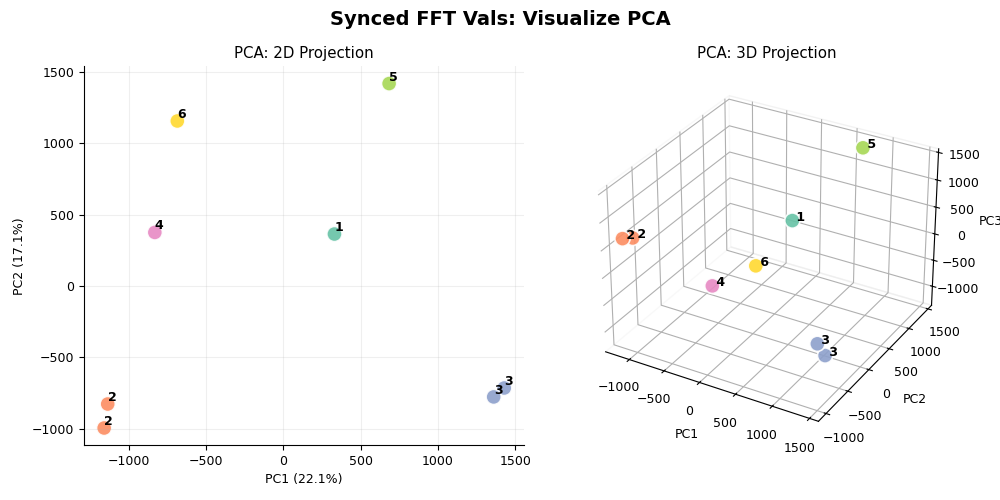

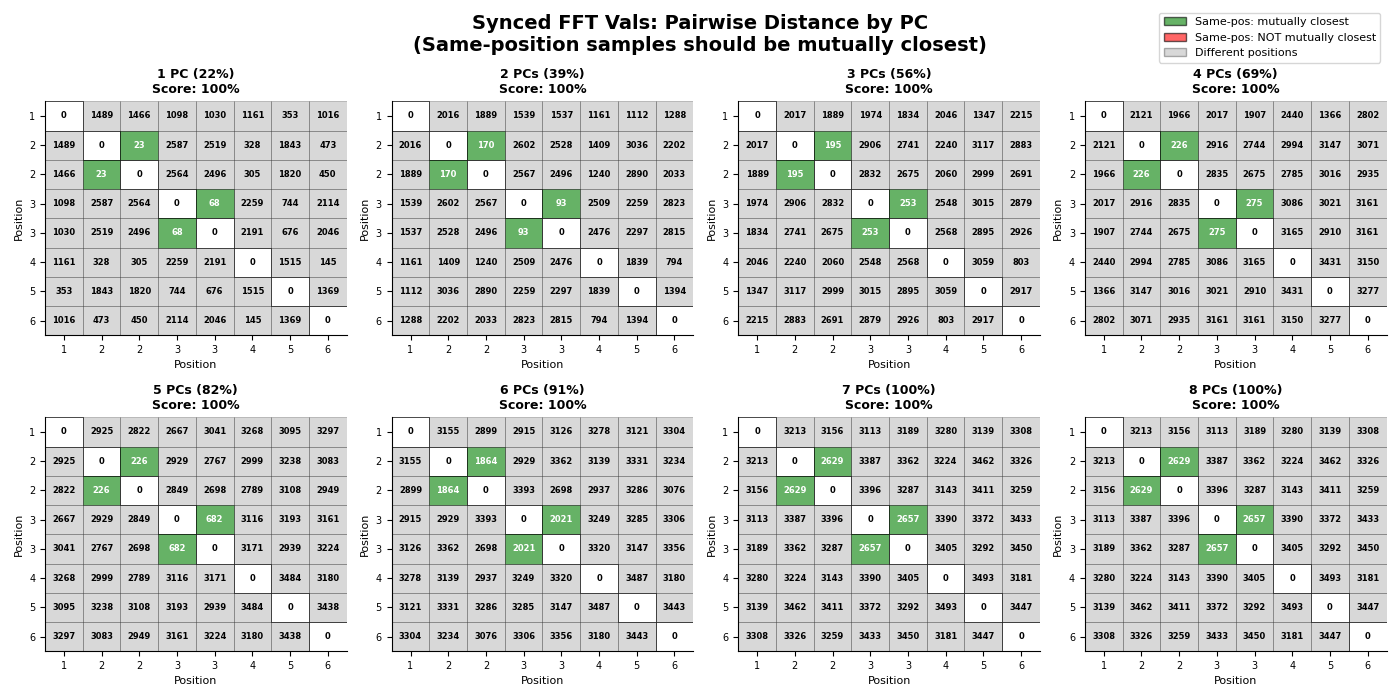

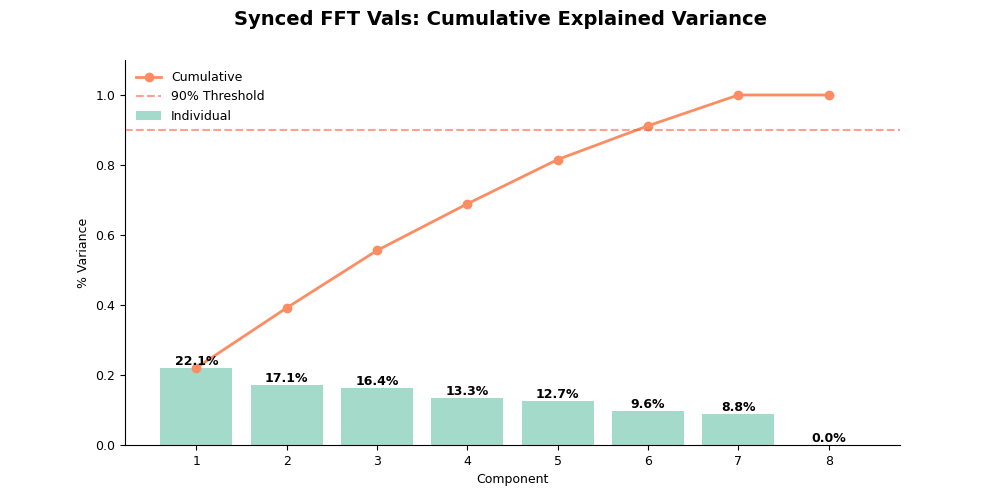

In [40]:
_ = run_all_pca(data, 'fft_val_synced', "Synced FFT Vals: ")

# 6. Compute Mode

In [41]:
from scipy.signal import find_peaks
from matplotlib.widgets import RangeSlider

In [42]:
def find_modes(freq, fft_val, n_modes=5, min_distance=100):
    """Find the top n_modes frequency peaks from mean FFT magnitude (averaged over lasers + x/y coordinate).

    Returns list of (frequency, magnitude, time) tuples sorted by frequency.
    Time is estimated assuming a log chirp from 50-2000 Hz over the recording duration.
    """

    mean_mag = fft_magnitude_mean(fft_val)
    peaks, _ = find_peaks(mean_mag, distance=min_distance)
    peak_mags = mean_mag[peaks]

    # Sort by magnitude and take top n_modes
    top_indices = np.argsort(peak_mags)[-n_modes:][::-1]
    top_peaks = peaks[top_indices]

    mode_freq = [freq[p] for p in sorted(top_peaks)]
    mode_fft_val = [fft_val[:, p:p+1, :] for p in sorted(top_peaks)] #(100, 11_000, 2)
    return mode_freq, mode_fft_val

In [52]:
# play around with these parameters until they look right using the plot_fft_by_position function
n_modes = 5 # 10
min_distance = 100

for name, d in data.items():
    mode_freq, mode_fft_val = find_modes(d['freq'], d['fft_val'], n_modes, min_distance)
    d['mode_freq'], d['mode_fft_val'] = mode_freq, mode_fft_val

    mode_freq_synced, mode_fft_val_synced = find_modes(d['freq'], d['fft_val_synced'])
    d['mode_freq_synced'], d['mode_fft_val_synced'] = mode_freq_synced, mode_fft_val_synced

In [103]:
def plot_fft_with_modes(data, mode_freq_key='mode_freq', mode_fft_val_key='mode_fft_val'):
    fig, axes = plt.subplots(2, 3, figsize=(15, 5))
    axes = axes.flatten()

    min_freq = min([min(d.get(mode_freq_key, d['freq'].min())) for d in data.values()])
    max_freq = max([max(d.get(mode_freq_key, d['freq'].max())) for d in data.values()])

    for d in data.values():
        # skip duplicates
        if d['duplicate_idx'] != 1: continue
        ax_idx = d['position'] - 1
        ax = axes[ax_idx]
        freq, fft_val = d['freq'], d['fft_val']

        mean, std = fft_magnitude_mean(fft_val), fft_magnitude_std(fft_val)
        ax.plot(freq, mean, lw=0.8)
        ax.fill_between(freq, mean - std, mean + std, alpha=0.3)

        if mode_freq_key in d:
            for mode_freq, mode_fft_val in zip(d[mode_freq_key], d[mode_fft_val_key]):
                mode_fft_mag = fft_magnitude_mean(mode_fft_val)
                ax.axvline(mode_freq, color='red', linestyle='--', alpha=0.7, lw=1)
                ax.scatter([mode_freq], [mode_fft_mag], color='red', s=50, zorder=5)
                ax.annotate(f'{mode_freq:.0f} Hz', (mode_freq, mode_fft_mag), textcoords='offset points',
                           xytext=(5, 5), fontsize=8, color='red')

        ax.set(title=f'Position {d['position']}', xlim=(min_freq*0.9, max_freq*1.1))
        ax.grid(True, alpha=0.3)
        n_modes = len(d[mode_freq_key])

    # 1. Set your labels as you did before
    for ax in axes[-3:]:
        ax.set_xlabel('Frequency (Hz)')

    for ax in axes[::3]:
        ax.set_ylabel('Magnitude')

    # 2. Clean up the ticks based on the presence of those labels
    for ax in axes.flatten():
        ax.tick_params(axis='x', labelbottom=bool(ax.get_xlabel()), bottom=bool(ax.get_xlabel()))
        ax.tick_params(axis='y', labelleft=bool(ax.get_ylabel()), left=bool(ax.get_ylabel()))


    plt.tight_layout(rect=[0, 0, 1, 0.95])
    title_suffix = f"\n{d[mode_freq_key]}" if 'cannonical' in mode_freq_key else ""
    fig.suptitle(f'FFT Magnitude {n_modes} modes'+title_suffix, fontsize=12)

    # Add range slider for frequency zoom
    ax_slider = fig.add_axes([0.15, 0.02, 0.7, 0.03])
    slider = RangeSlider(ax_slider, 'Freq (Hz)', freq.min(), freq.max(), valinit=(min_freq*0.9, max_freq*1.1))

    def update(val):
        freq_min, freq_max = val
        for ax in axes: ax.set_xlim(freq_min, freq_max)
        fig.canvas.draw_idle()
    slider.on_changed(update)

    # Keep a reference to the slider to prevent garbage collection
    fig._slider = slider
    return fig

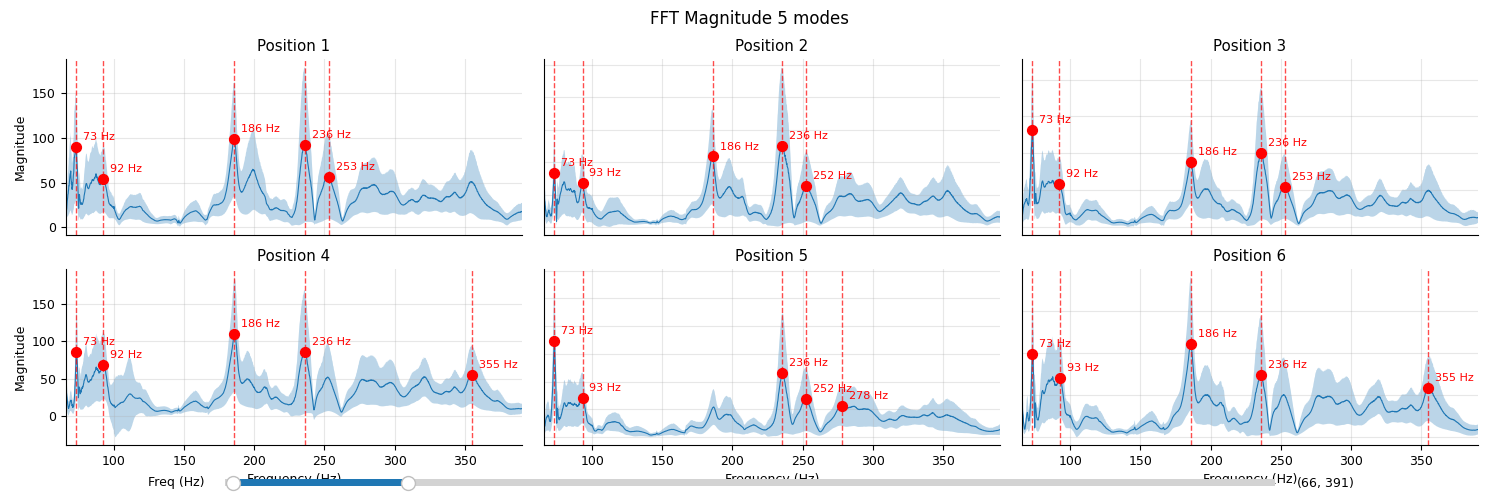

In [104]:
fig = plot_fft_with_modes(data)

In [105]:
def plot_mode_frequency_overlap(data):
    """Bubble plot showing mode frequencies across positions.

    X-axis: frequency (Hz)
    Y-axis: position
    Marker size: proportional to mean FFT magnitude at that mode
    """
    fig, ax = plt.subplots(figsize=(14, 6))

    positions = []
    frequencies = []
    magnitudes = []

    for name, d in data.items():
        if d['duplicate_idx'] != 1:
            continue

        pos = d['position']
        for mode_freq, mode_fft_val in zip(d['mode_freq'], d['mode_fft_val']):
            mag = fft_magnitude_mean(mode_fft_val).item()
            positions.append(pos)
            frequencies.append(mode_freq)
            magnitudes.append(mag)

    n_modes = len(d['mode_freq'])
    positions = np.array(positions)
    frequencies = np.array(frequencies)
    magnitudes = np.array(magnitudes)

    # Draw horizontal lines for each position
    unique_positions = sorted(set(positions))
    for pos in unique_positions:
        ax.axhline(pos, color='gray', linestyle='-', alpha=0.3, linewidth=1)

    # Normalize magnitudes for marker sizes (scale to reasonable range)
    size_scale = 500
    sizes = (magnitudes / magnitudes.max()) * size_scale

    # Color by even/odd position
    colors = ['tab:blue' if pos % 2 == 0 else 'tab:orange' for pos in positions]

    scatter = ax.scatter(frequencies, positions, s=sizes, alpha=0.6,
                         c=colors, edgecolor='black', linewidth=0.5)

    # Add magnitude labels on each bubble
    for freq, pos, mag in zip(frequencies, positions, magnitudes):
        ax.annotate(f'{mag:.0f}', (freq, pos), ha='center', va='center',
                    fontsize=7, fontweight='bold', color='black')

    ax.set_xlabel('Frequency (Hz)', fontsize=11)
    ax.set_ylabel('Position', fontsize=11)
    ax.set_yticks(unique_positions)
    ax.grid(True, alpha=0.3, axis='x')

    # Add size legend
    legend_sizes = [0.25, 0.5, 1.0]
    legend_labels = [f'{int(s * magnitudes.max()):.0f}' for s in legend_sizes]
    for s, label in zip(legend_sizes, legend_labels):
        ax.scatter([], [], s=s * size_scale, c='gray', alpha=0.6, edgecolor='black')

    # Add color legend for even/odd
    ax.scatter([], [], s=100, c='tab:blue', alpha=0.6, edgecolor='black', label='Even positions')
    ax.scatter([], [], s=100, c='tab:orange', alpha=0.6, edgecolor='black', label='Odd positions')
    ax.legend(title='Position Parity', loc='upper right', frameon=True)

    fig.suptitle(f'{n_modes} Mode Frequencies Across Positions\n(marker size ~ mean FFT magnitude)',
                 fontsize=12, fontweight='bold')
    plt.tight_layout()
    return fig

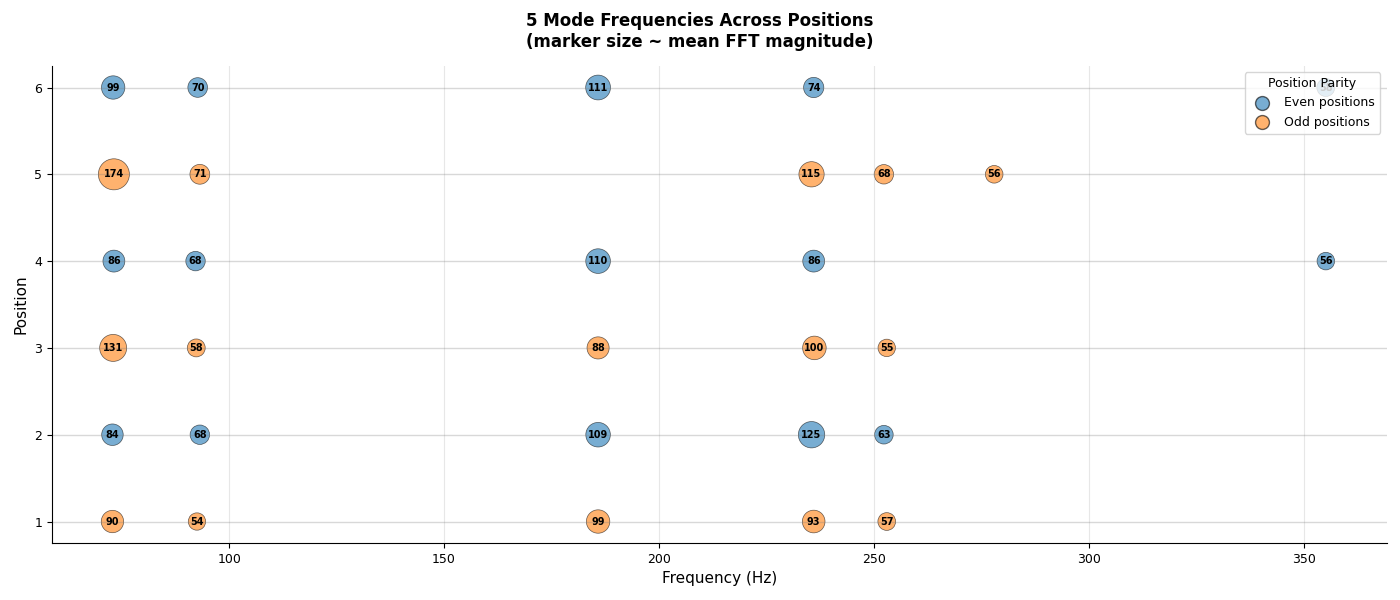

In [106]:
fig = plot_mode_frequency_overlap(data)
plt.show()

Okay, from here we need to define a cannonical pair of mode frequencies. For some reason, we seem to have 4 modes for position 6, 4. We'll just use the modes from position 4.

In [115]:
for name, d in data.items():
    d['cannonical_mode_freqs'] = np.array(data['cube-pos4-01']['mode_freq'])

    cannonical_mode_synced_fft_val = np.empty((len(d['cannonical_mode_freqs']), 100, 1, 2), dtype=np.complex64)
    for i, freq in enumerate(d['cannonical_mode_freqs']):
        idx = np.argmin(np.abs(d['freq'] - freq))
        cannonical_mode_synced_fft_val[i:i+1, :, :, :] = d['fft_val_synced'][:, idx:idx+1, :]
    d['cannonical_mode_synced_fft_val'] = cannonical_mode_synced_fft_val

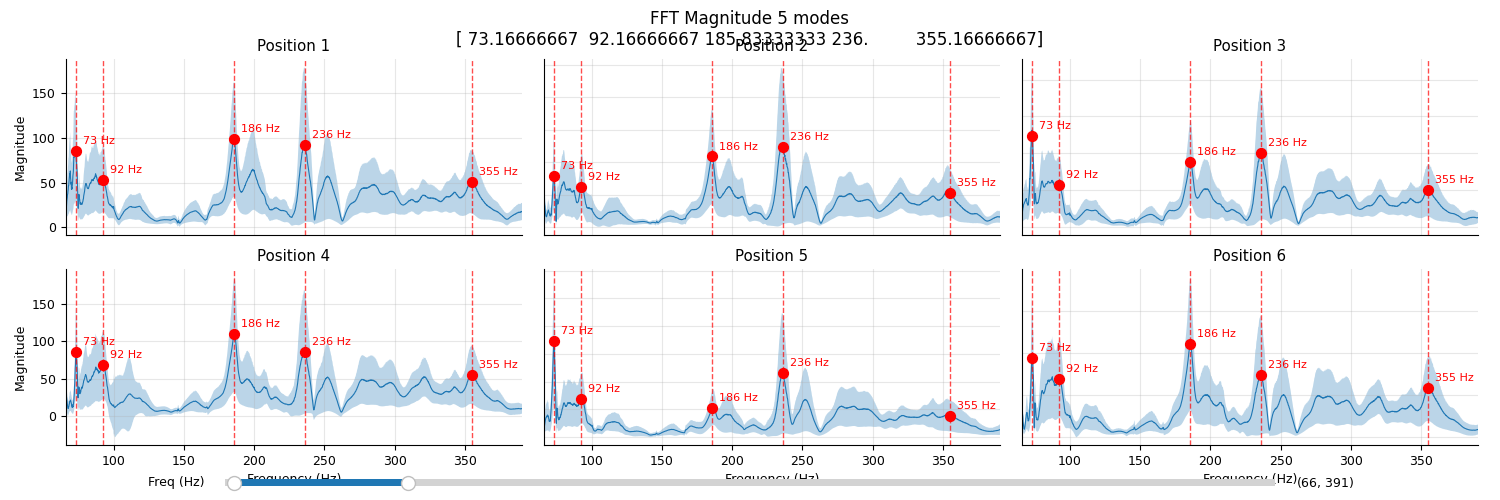

In [116]:
fig = plot_fft_with_modes(data, 'cannonical_mode_freqs', 'cannonical_mode_synced_fft_val')

In [131]:
# n_points = np.sqrt(d['shifts'].shape[0]).astype(int)
# f0 = d['cannonical_mode_freqs'][0]
# FFT_f0_norm = d['cannonical_mode_synced_fft_val'][0].squeeze()
# print(f0.shape, FFT_f0_norm.shape)

# x_coords, y_coords = np.meshgrid(np.arange(n_points), np.arange(n_points))
# U = np.real(FFT_f0_norm[:, 0]).reshape(n_points, n_points)
# V = np.real(FFT_f0_norm[:, 1]).reshape(n_points, n_points)

# # Compute magnitude of all vectors (for auto quiver scaling)
# magnitudes = np.sqrt(U**2 + V**2)
# max_len = np.max(magnitudes)
# desired_frac = 0.2
# scale_auto = max_len / desired_frac

# # Coordinates for plotting (index grid and metric grid)
# D  = 0.01
# X_m = x_coords * D
# Y_m = y_coords * D

# fig, ax = plt.subplots(figsize=(12, 8))

# ax = fig.add_subplot(1, 2, 1)
# ax.quiver(x_coords, y_coords, U, V, scale=scale_auto)
# ax.set_title(f"Mode shape at {f0:.2f} Hz (∂Z/∂x, ∂Z/∂y)")
# ax.set_xlim(-0.5, n_points - 0.5)
# ax.set_ylim(-0.5, n_points - 0.5)
# ax.set_aspect('equal', adjustable='box')
# ax.set_xlabel('x index')
# ax.set_ylabel('y index')
# ax.grid(True, linestyle='--', alpha=0.3)

# plt.tight_layout()
# plt.show()

In [135]:
d.keys()

dict_keys(['object', 'position', 'duplicate_idx', 'fs', 'path', 'raw_shifts', 'timesteps', 'fft_val_raw', 'freq_raw', 'shifts', 'fft_val', 'freq', 'fft_val_synced', 'mode_freq', 'mode_fft_val', 'mode_freq_synced', 'mode_fft_val_synced', 'temp_fft', 'cannonical_mode_freqs', 'cannonical_mode_fft_val', 'cannonical_mode_synced_fft_val'])

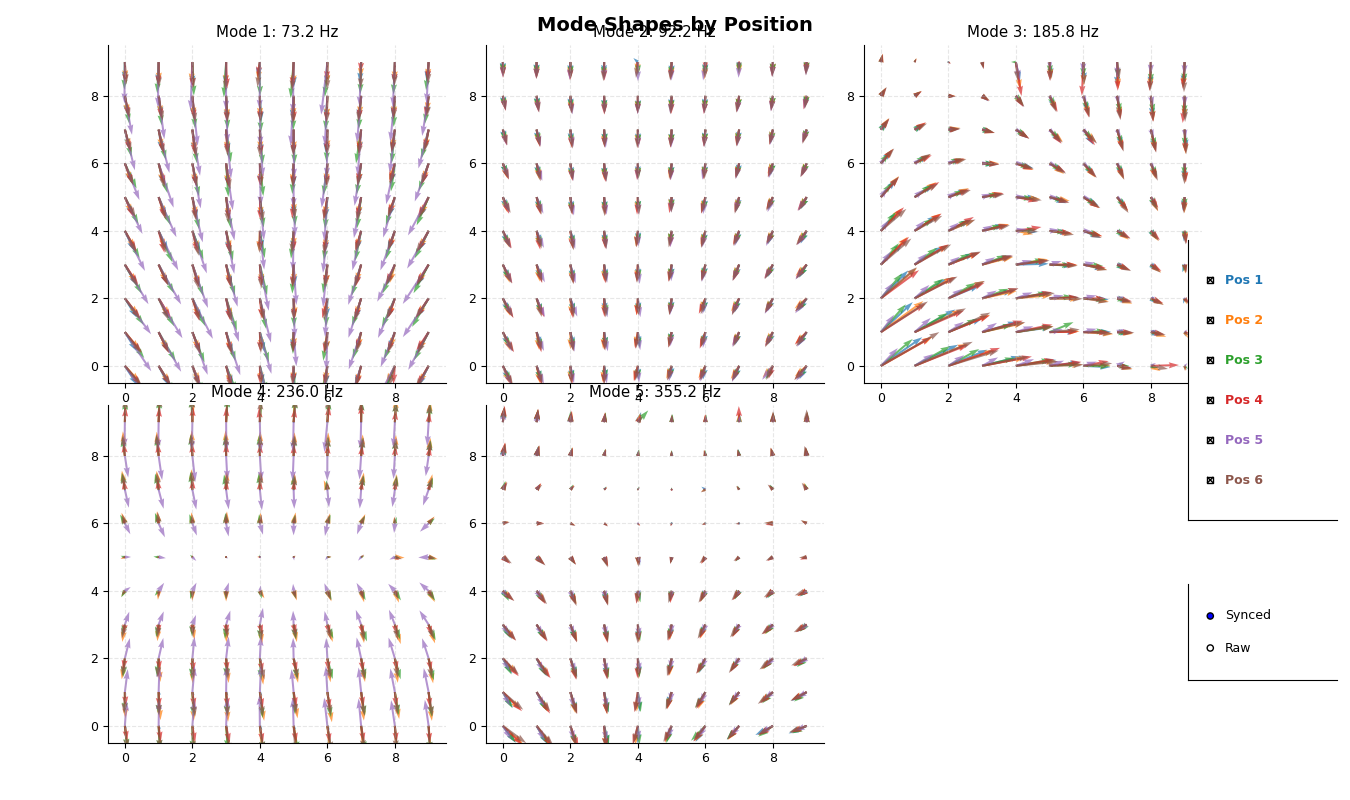

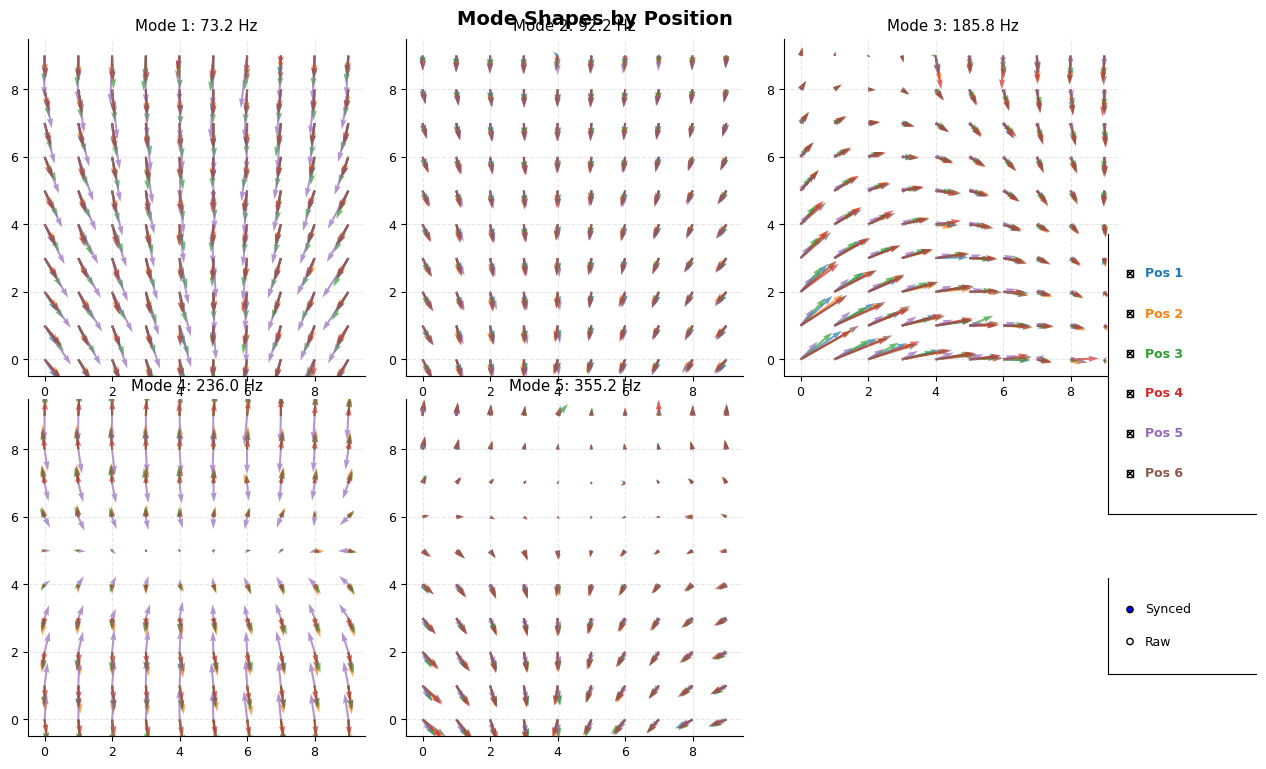

In [ ]:
from matplotlib.widgets import CheckButtons, RadioButtons

# Color palette for positions
POSITION_COLORS = {
    1: 'tab:blue',
    2: 'tab:orange',
    3: 'tab:green',
    4: 'tab:red',
    5: 'tab:purple',
    6: 'tab:brown',
}

# Available FFT data keys
FFT_KEYS = {
    'Synced': 'cannonical_mode_synced_fft_val',
    'Raw': 'mode_fft_val',
}


def get_position_data(data: dict, position: int) -> dict:
    """Get data entry for a position (first duplicate only)."""
    return next(d for d in data.values() if d['position'] == position and d['duplicate_idx'] == 1)


def get_mode_uv(d: dict, mode_idx: int, n_points: int, fft_key: str):
    """Extract U, V quiver components for a given mode."""
    fft_data = d[fft_key][mode_idx].squeeze()
    U = np.real(fft_data[:, 0]).reshape(n_points, n_points)
    V = np.real(fft_data[:, 1]).reshape(n_points, n_points)
    return U, V


def compute_scale(uv_list: list, desired_frac: float = 0.2) -> float:
    """Compute quiver scale from list of (U, V) tuples."""
    max_mag = max(np.max(np.sqrt(U**2 + V**2)) for U, V in uv_list)
    return max_mag / desired_frac if max_mag > 0 else 1.0


class InteractiveModeQuiver:
    """Interactive quiver plot for comparing mode shapes across box positions."""

    def __init__(self, data: dict, n_cols: int = 3, desired_frac: float = 0.2):
        self.data = data
        self.n_cols = n_cols
        self.desired_frac = desired_frac

        # Get available positions
        self.positions = sorted(set(d['position'] for d in data.values() if d['duplicate_idx'] == 1))
        self.active = {pos: True for pos in self.positions}  # All active initially

        # FFT key selection
        self.fft_key = FFT_KEYS['Synced']  # Default to synced

        # Get dimensions
        d0 = get_position_data(data, self.positions[0])
        self.n_modes = len(d0['cannonical_mode_freqs'])
        self.n_points = int(np.sqrt(d0['shifts'].shape[0]))
        self.freqs = d0['cannonical_mode_freqs']

        # Coordinate grid
        self.x_coords, self.y_coords = np.meshgrid(
            np.arange(self.n_points), np.arange(self.n_points)
        )

        # Storage for quiver objects
        self.quivers = {}  # {(mode_idx, pos): quiver_obj}

        self._setup_figure()
        self._draw_all()

    def _setup_figure(self):
        """Create figure with subplots and widgets."""
        n_rows = int(np.ceil(self.n_modes / self.n_cols))

        self.fig = plt.figure(figsize=(4 * self.n_cols + 1.5, 4 * n_rows))

        # Main axes for mode plots
        self.axes = []
        for i in range(self.n_modes):
            row, col = divmod(i, self.n_cols)
            ax = self.fig.add_axes([
                0.08 + col * 0.28,
                0.95 - (row + 1) * (0.9 / n_rows) + 0.02,
                0.25,
                0.85 / n_rows
            ])
            ax.set_xlim(-0.5, self.n_points - 0.5)
            ax.set_ylim(-0.5, self.n_points - 0.5)
            ax.set_aspect('equal', adjustable='box')
            ax.set_title(f"Mode {i + 1}: {self.freqs[i]:.1f} Hz")
            ax.grid(True, linestyle='--', alpha=0.3)
            self.axes.append(ax)

        # Position checkbox
        ax_check = self.fig.add_axes([0.88, 0.35, 0.11, 0.35])
        labels = [f"Pos {p}" for p in self.positions]
        actives = [self.active[p] for p in self.positions]
        colors = [POSITION_COLORS[p] for p in self.positions]

        self.check = CheckButtons(ax_check, labels, actives)
        for label, color in zip(self.check.labels, colors):
            label.set_color(color)
            label.set_fontweight('bold')
        self.check.on_clicked(self._on_check)

        # FFT key radio buttons
        ax_radio = self.fig.add_axes([0.88, 0.15, 0.11, 0.12])
        self.radio = RadioButtons(ax_radio, list(FFT_KEYS.keys()), active=0)
        self.radio.on_clicked(self._on_radio)

        self.fig.suptitle('Mode Shapes by Position', fontsize=14, fontweight='bold')

    def _draw_all(self):
        """Draw quivers for all active positions."""
        # Clear existing quivers
        for q in self.quivers.values():
            q.remove()
        self.quivers.clear()

        # Collect all UV data for scale computation
        all_uv = []
        for pos in self.positions:
            if not self.active[pos]:
                continue
            d = get_position_data(self.data, pos)
            for mode_idx in range(self.n_modes):
                all_uv.append(get_mode_uv(d, mode_idx, self.n_points, self.fft_key))

        if not all_uv:
            self.fig.canvas.draw_idle()
            return

        scale = compute_scale(all_uv, self.desired_frac)

        # Draw quivers
        for pos in self.positions:
            if not self.active[pos]:
                continue
            d = get_position_data(self.data, pos)
            color = POSITION_COLORS[pos]

            for mode_idx, ax in enumerate(self.axes):
                U, V = get_mode_uv(d, mode_idx, self.n_points, self.fft_key)
                q = ax.quiver(
                    self.x_coords, self.y_coords, U, V,
                    scale=scale, color=color, alpha=0.7
                )
                self.quivers[(mode_idx, pos)] = q

        self.fig.canvas.draw_idle()

    def _on_check(self, label):
        """Handle checkbox click."""
        pos = int(label.split()[-1])
        self.active[pos] = not self.active[pos]
        self._draw_all()

    def _on_radio(self, label):
        """Handle radio button selection."""
        self.fft_key = FFT_KEYS[label]
        self._draw_all()

    def show(self):
        """Display the interactive plot."""
        plt.show()
        return self.fig


# Example usage
viewer = InteractiveModeQuiver(data)
viewer.show()

In [110]:
# import numpy as np
# import matplotlib.pyplot as plt
# import matplotlib.gridspec as gs
# from matplotlib.widgets import Slider, Button
# from matplotlib.animation import FFMpegWriter
# from IPython.display import Video, display

# class PlotShifts:
#     """Quiver plot visualization for surface vibrations across cube positions."""

#     def __init__(self, data, scale=1.0):
#         """
#         Args:
#             data: Dict with position keys containing 'shifts' (n_lasers, n_frames, 2) and 'timesteps'
#         """
#         self.data = data
#         self.pos = list(data.keys())
#         self.shifts = {p: data[p]['shifts'] for p in self.pos}
#         self.timesteps = data[self.pos[0]]['timesteps']
#         self.T = len(self.timesteps)
#         self.n = int(np.sqrt(data[self.pos[0]]['shifts'].shape[0]))
#         self.X, self.Y = np.meshgrid(np.arange(self.n), np.arange(self.n))
#         self.scale = scale

#         self.fig = None
#         self.axs = None
#         self.qs = None

#     def _init_plot(self, t_start):
#         """Create figure with 6 quiver subplots."""
#         self.fig = plt.figure(figsize=(10, 9))
#         G = gs.GridSpec(5, 3, height_ratios=[4, 4, 0.7, 0.7, 0.4])
#         self.axs = [self.fig.add_subplot(G[i//3, i%3]) for i in range(len(self.pos))]
#         self.qs = []

#         for ax, p in zip(self.axs, self.pos):
#             v = self.shifts[p][:, 0].reshape(self.n, self.n, 2)
#             self.qs.append(ax.quiver(self.X, self.Y, v[..., 0], v[..., 1], scale=self.scale))
#             ax.set(title=f"Position {p}", aspect="equal", xlim=(-0.5, self.n-0.5), ylim=(-0.5, self.n-0.5))

#         self.fig.suptitle(f"Surface Vibrations t={self.timesteps[t_start]:.3f}s {t_start=}")
#         self.fig.subplots_adjust(hspace=0.5)
#         return self.fig

#     def _update(self, t_idx, scale=None, redraw=True):
#         """Update all quiver plots to time index t_idx."""
#         if scale is not None:
#             self.scale = scale
#         for i, p in enumerate(self.pos):
#             v = self.shifts[p][:, t_idx].reshape(self.n, self.n, 2)
#             self.qs[i].remove()
#             self.qs[i] = self.axs[i].quiver(self.X, self.Y, v[..., 0], v[..., 1], scale=self.scale)
#         self.fig.suptitle(f"Surface Vibrations t={self.timesteps[t_idx]:.3f}s {t_idx.item()=}")
#         if redraw:
#             self.fig.canvas.draw_idle()

#     def static(self, t_idx=0):
#         """Create a static plot at time index t_idx."""
#         self._init_plot(t_idx)
#         if t_idx > 0:
#             self._update(t_idx)
#         return self.fig

#     def interactive(self, t_start=0, t_end=None):
#         """Create interactive plot with sliders and step buttons."""
#         if t_end is None: t_end = self.T - 1
#         self._init_plot(t_start)
#         G = self.axs[0].get_gridspec()

#         # Sliders
#         self.time_slider = Slider(self.fig.add_subplot(G[2, :]), "t (s)",
#                                    self.timesteps[t_start], self.timesteps[t_end], valinit=self.timesteps[0])
#         self.scale_slider = Slider(self.fig.add_subplot(G[3, :]), "scale", 0.1, 10, valinit=self.scale)

#         def on_change(_):
#             t_idx = np.argmin(np.abs(self.timesteps - self.time_slider.val))
#             self._update(t_idx, self.scale_slider.val)

#         self.time_slider.on_changed(on_change)
#         self.scale_slider.on_changed(on_change)

#         # Step buttons
#         def get_idx():
#             return np.argmin(np.abs(self.timesteps - self.time_slider.val))

#         self.btn_left = Button(self.fig.add_subplot(G[4, 0]), "◀ Step")
#         self.btn_right = Button(self.fig.add_subplot(G[4, 2]), "Step ▶")
#         self.btn_left.on_clicked(lambda _: self.time_slider.set_val(self.timesteps[max(0, get_idx()-1)]))
#         self.btn_right.on_clicked(lambda _: self.time_slider.set_val(self.timesteps[min(self.T-1, get_idx()+1)]))

#         # Keep references to prevent garbage collection
#         self.fig._widgets = [self.time_slider, self.scale_slider, self.btn_left, self.btn_right]
#         return self.fig

#     def save(self, filename="shifts.mp4", t_start=0, t_end=None, step=1, fps=30, dpi=150):
#         # Fix for the TypeError: handle positional ints if filename was skipped
#         if isinstance(filename, int):
#             t_end = t_start
#             t_start = filename
#             filename = "shifts.mp4"

#         if t_end is None: t_end = self.T

#         import matplotlib
#         orig_backend = matplotlib.get_backend()
#         plt.switch_backend('Agg')

#         try:
#             self._init_plot(t_start)
#             writer = FFMpegWriter(fps=fps, bitrate=1800)
#             with writer.saving(self.fig, filename, dpi):
#                 for t_idx in range(t_start, t_end, step):
#                     self._update(t_idx, redraw=False)
#                     writer.grab_frame()
#         finally:
#             plt.close(self.fig)
#             plt.switch_backend(orig_backend)
#             print(f"Saved {filename}")

#         # Display the video in the notebook cell
#         return display(Video(filename, embed=True, width=600))

In [125]:
D        = 0.01

def reconstruct_surface_from_gradients(
    DX: np.ndarray,
    DY: np.ndarray,
    dx: float = 1.0,
    dy: float = 1.0,
    smoothing_lambda: float | None = None,
    smoothing_length: float | None = None,
    zero_mean: bool = True,
) -> np.ndarray:
    """
    Reconstruct a REAL surface Z[x,y] from REAL partial derivatives:
        DX = ∂Z/∂x  (axis-0),  DY = ∂Z/∂y  (axis-1),
    on a uniform grid using the Frankot–Chellappa method.

    Solves in Fourier domain (periodic BCs) the LS problem:
        minimize_Z ||DX - ∂Z/∂x||^2 + ||DY - ∂Z/∂y||^2  (+ optional Tikhonov on Z)

    Closed form:
        Ẑ(kx,ky) = ( i kx D̂X + i ky D̂Y ) / ( kx^2 + ky^2 + λ^2 )

    Parameters
    ----------
    DX, DY : (Nx, Ny) real arrays
        Spatial derivatives sampled on a rectangular, uniform grid.
        Axis-0 ↔ x, axis-1 ↔ y.
    dx, dy : float
        Grid spacings along x and y (same units as Z coordinates).
    smoothing_lambda : float or None
        Optional Tikhonov (screened Poisson) strength λ [radians per unit length].
        Larger λ ⇒ smoother Z. If None and `smoothing_length` is given, λ = 2π/ℓ.
    smoothing_length : float or None
        Convenience alternative to set λ via a physical length scale ℓ.
    zero_mean : bool
        If True, remove the mean of Z (height offset is undetermined anyway).

    Returns
    -------
    Z : (Nx, Ny) real array
        Reconstructed surface.
    """
    if DX.shape != DY.shape:
        raise ValueError("DX and DY must have the same shape (Nx, Ny).")
    if not (np.isrealobj(DX) and np.isrealobj(DY)):
        raise ValueError("DX and DY must be real arrays.")

    DX = np.asarray(DX, dtype=np.float64)
    DY = np.asarray(DY, dtype=np.float64)
    Nx, Ny = DX.shape

    # Angular spatial frequencies consistent with numpy FFTs
    kx = 2.0 * np.pi * np.fft.fftfreq(Nx, d=dx)[:, None]   # (Nx, 1)
    ky = 2.0 * np.pi * np.fft.fftfreq(Ny, d=dy)[None, :]   # (1, Ny)

    # FFT of gradients
    DX_hat = np.fft.fft2(DX)
    DY_hat = np.fft.fft2(DY)

    # Smoothing λ (screened Poisson)
    if smoothing_lambda is None:
        if smoothing_length is not None and smoothing_length > 0:
            lam = 2.0 * np.pi / float(smoothing_length)
        else:
            lam = 0.0
    else:
        lam = float(smoothing_lambda)
        if lam < 0:
            raise ValueError("smoothing_lambda must be ≥ 0")

    denom = (kx**2 + ky**2)
    if lam > 0.0:
        denom = denom + lam**2

    # Avoid division by zero at DC; numerator is 0 there for consistent gradients
    denom = denom.astype(np.float64)
    denom[0, 0] = np.inf

    # Frankot–Chellappa least-squares solution
    Z_hat = (-1j * kx * DX_hat - 1j * ky * DY_hat) / denom
    #Z_hat = (1j * kx * DX_hat + 1j * ky * DY_hat) / denom
    Z_hat[0, 0] = 0.0  # fix the arbitrary constant height

    Z = np.fft.ifft2(Z_hat).real

    if zero_mean:
        Z -= Z.mean()

    return Z

In [127]:
# n_points = np.sqrt(d['shifts'].shape[0]).astype(int)
# f0 = d['cannonical_mode_freqs'][0]
# FFT_f0_norm = d['cannonical_mode_synced_fft_val'][0].squeeze()
# print(f0.shape, FFT_f0_norm.shape)

# x_coords, y_coords = np.meshgrid(np.arange(n_points), np.arange(n_points))
# U = np.real(FFT_f0_norm[:, 0]).reshape(n_points, n_points)
# V = np.real(FFT_f0_norm[:, 1]).reshape(n_points, n_points)

# Z = reconstruct_surface_from_gradients(U.T, V.T, dx=D, dy=D, smoothing_length=0.1,zero_mean=True)
# # Compute magnitude of all vectors (for auto quiver scaling)
# magnitudes = np.sqrt(U**2 + V**2)
# max_len = np.max(magnitudes)
# desired_frac = 0.2
# scale_auto = max_len / desired_frac

# # Coordinates for plotting (index grid and metric grid)
# X_m = x_coords * D
# Y_m = y_coords * D

# fig = plt.figure(figsize=(12, 8))

# # --- (1,2,1): Quiver of gradients (mode shape) ---
# ax1 = fig.add_subplot(1, 2, 1)
# ax1.quiver(x_coords, y_coords, U, V, scale=scale_auto)
# ax1.set_title(f"Mode shape at {f0:.2f} Hz (∂Z/∂x, ∂Z/∂y)")
# ax1.set_xlim(-0.5, n_points - 0.5)
# ax1.set_ylim(-0.5, n_points - 0.5)
# ax1.set_aspect('equal', adjustable='box')
# ax1.set_xlabel('x index')
# ax1.set_ylabel('y index')
# ax1.grid(True, linestyle='--', alpha=0.3)

# # --- (1,2,2): 3D surface of Z(x,y) ---
# ax2 = fig.add_subplot(1, 2, 2, projection='3d')
# # If you prefer millimeters, use (Z*1e3) and label accordingly.
# surf = ax2.plot_surface(X_m, Y_m, Z.T, rstride=1, cstride=1,
#                         linewidth=0, antialiased=True, shade=True)
# ax2.set_title("Reconstructed Surface Z(x,y)")
# ax2.set_xlabel('x [m]')
# ax2.set_ylabel('y [m]')
# ax2.set_zlabel('Z [m]')
# # Nice viewing angle + roughly equal aspect
# ax2.view_init(elev=30, azim=-60)

# plt.tight_layout()
# plt.show()

/var/folders/f6/vzqh7ynx4n3ft_sx36yv3gbm0000gn/T/ipykernel_85981/4182843189.py:155: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(figsize=(10, 5))


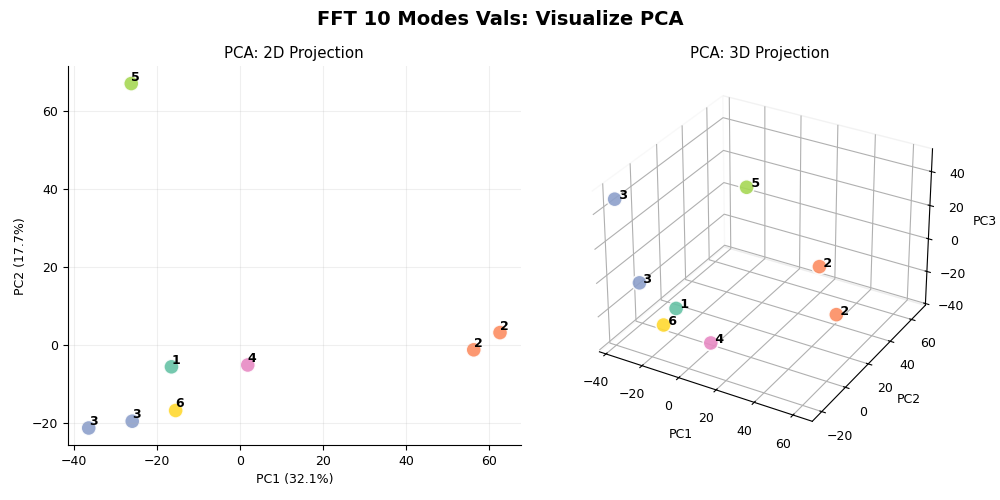

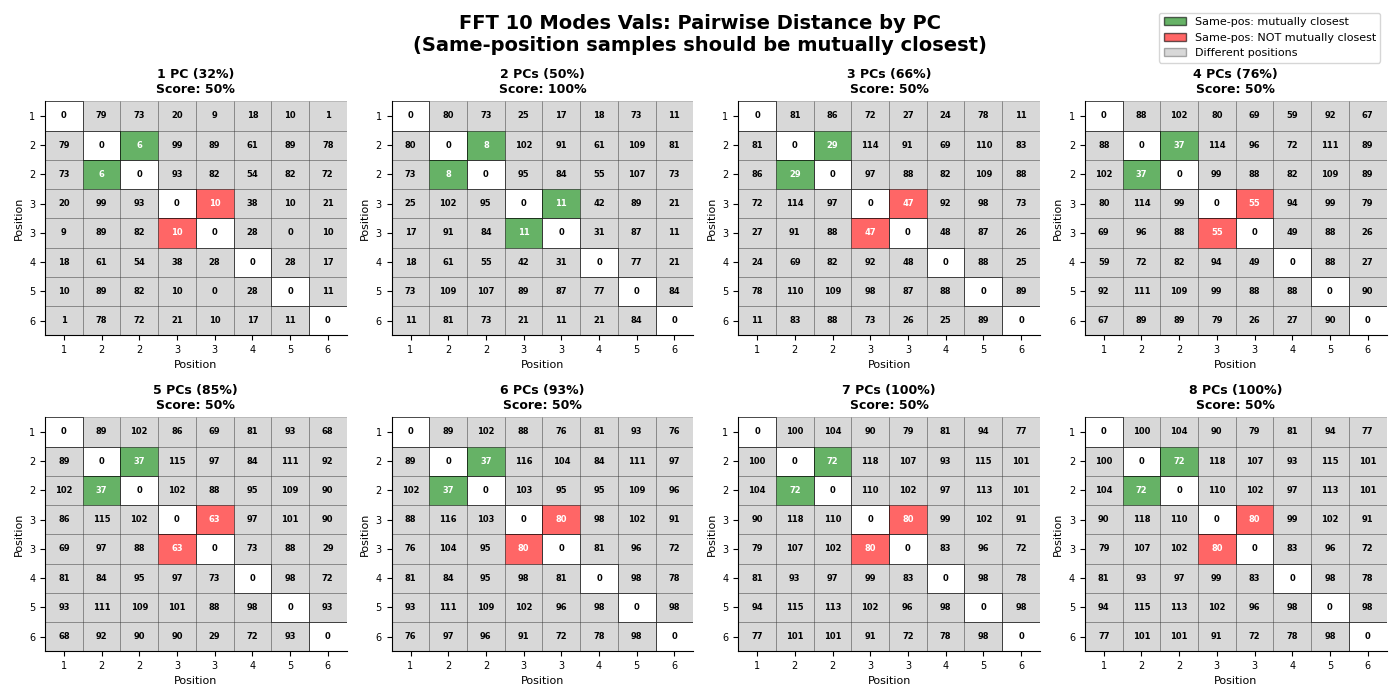

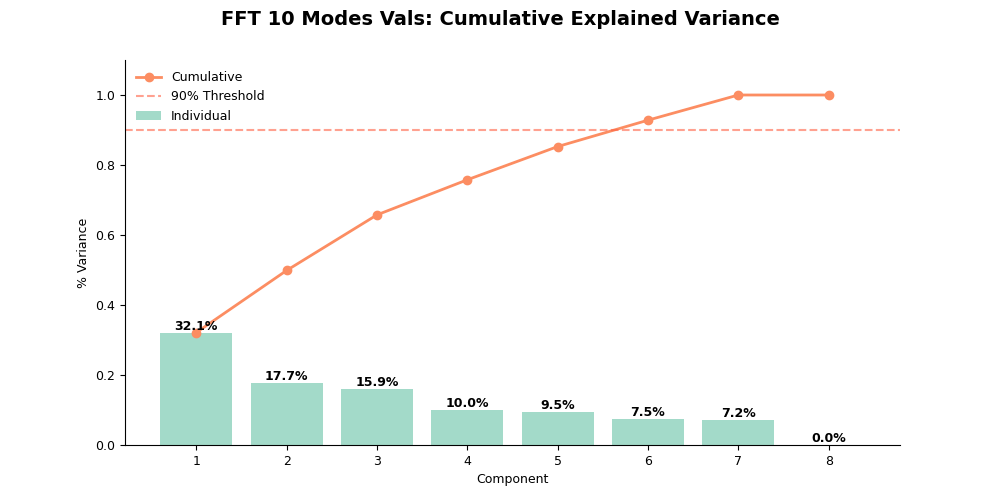

In [48]:
_ = run_all_pca(data, 'mode_fft_val', f"FFT {n_modes} Modes Vals: ")

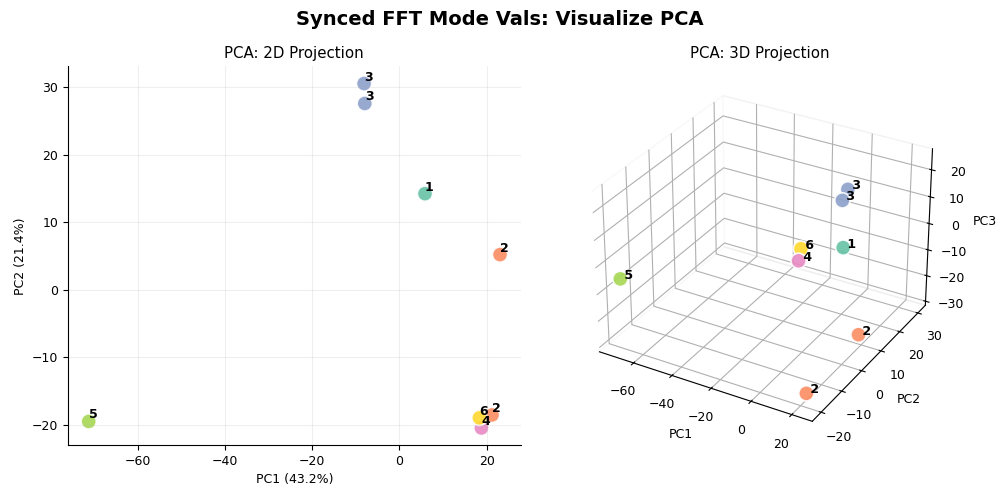

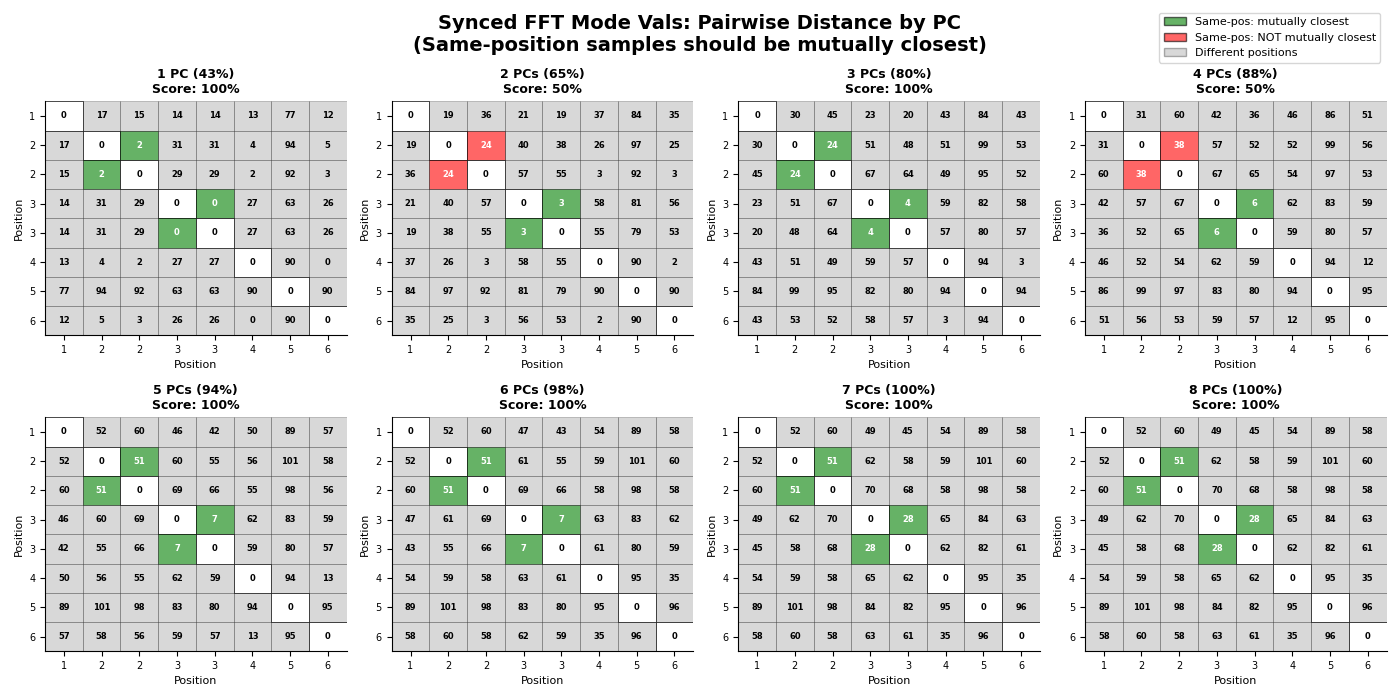

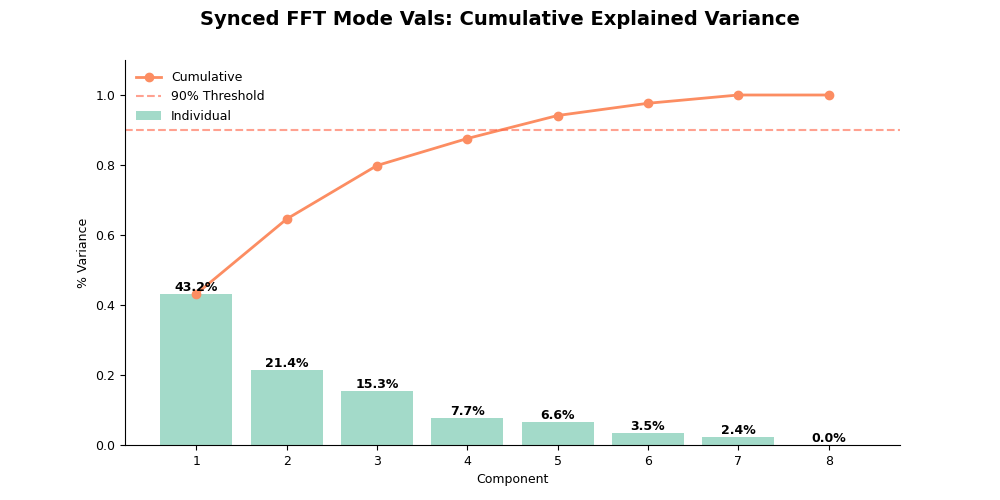

In [49]:
_ = run_all_pca(data, 'mode_fft_val_synced', "Synced FFT Mode Vals: ") # (100, 10, 2) N=10

In [50]:
def plot_mode_sensitivity(data, n_modes_list=[5, 10, 20, 50], n_components=10):
    """
    Plots cumulative variance for different n_modes counts.
    Automatically caps n_components based on dataset size to prevent ValueErrors.
    """
    # 1. Determine the absolute maximum components possible
    n_samples = len(data)
    max_possible = n_samples - 1 # Usually n_samples - 1 for centered data
    actual_components = min(n_components, max_possible)

    if actual_components < n_components:
        print(f"Note: Requested {n_components} PCs, but dataset only supports {actual_components}.")

    plt.figure(figsize=(10, 6))
    x_axis = range(1, actual_components + 1)

    # 2. Plot Baseline (Full FFT Data)
    print("Processing Baseline: Full FFT...")
    X_full, _ = prepare_pca_data(data, 'fft_val')
    _, pca_full = run_pca(X_full, n_components=actual_components)
    cum_var_full = np.cumsum(pca_full.explained_variance_ratio_)

    plt.plot(x_axis, cum_var_full, 'k--', linewidth=2.5, label='Baseline (All frequencies)', zorder=5)

    # 3. Iterate through different mode counts
    for i, n in enumerate(n_modes_list):
        # Update modes for each laser entry
        for name, d in data.items():
            _, d['temp_fft'] = find_modes(d['freq'], d['fft_val_synced'], n_modes=n)

        X, _ = prepare_pca_data(data, 'temp_fft')
        _, pca = run_pca(X, n_components=actual_components)

        cum_var = np.cumsum(pca.explained_variance_ratio_)
        plt.plot(x_axis, cum_var, 'o-', alpha=0.7, label=f'{n} Modes', color=plt.cm.plasma(i / len(n_modes_list)))

    # Formatting
    plt.axhline(0.9, color='red', linestyle=':', alpha=0.5, label='90% Variance')
    plt.title(f'PCA Explained Variance ({n_samples} samples)', fontsize=12, fontweight='bold')
    plt.xlabel('Number of Principal Components')
    plt.ylabel('Cumulative Explained Variance')
    plt.xticks(x_axis)
    plt.ylim(0, 1.05)
    plt.legend(frameon=False, loc='lower right')
    plt.grid(True, alpha=0.15)
    plt.tight_layout()

    return plt.gcf()

Note: Requested 8 PCs, but dataset only supports 7.
Processing Baseline: Full FFT...


ValueError: all the input array dimensions except for the concatenation axis must match exactly, but along dimension 1, the array at index 0 has size 37200 and the array at index 1 has size 37600

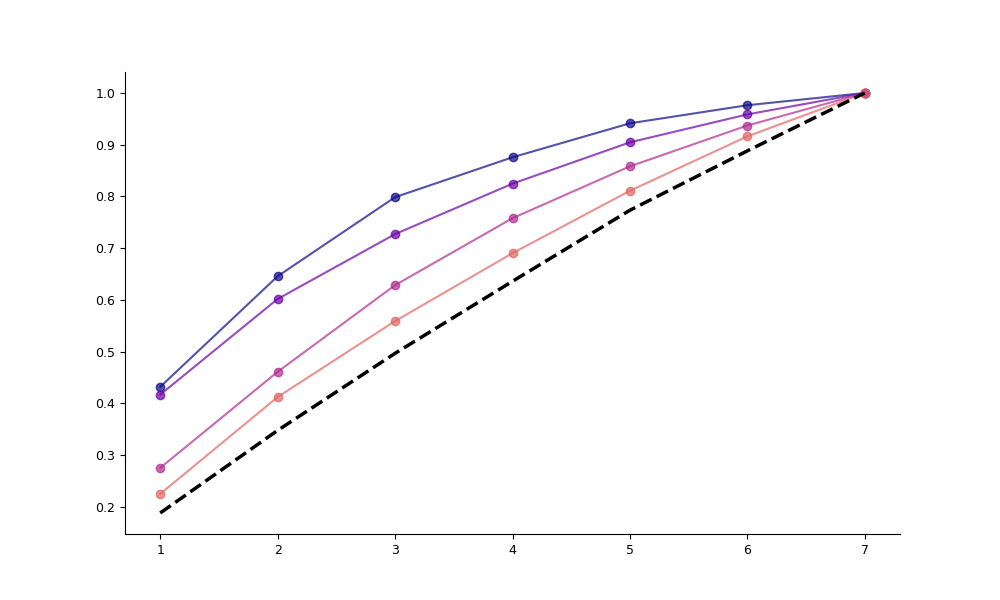

In [51]:
fig_sensitivity = plot_mode_sensitivity(data, n_modes_list=[5, 15, 30, 60, 120], n_components=8)

In [72]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gs
from matplotlib.widgets import Slider, Button
from matplotlib.animation import FFMpegWriter
from IPython.display import Video, display

class PlotShifts:
    """Quiver plot visualization for surface vibrations across cube positions."""

    def __init__(self, data, scale=1.0):
        """
        Args:
            data: Dict with position keys containing 'shifts' (n_lasers, n_frames, 2) and 'timesteps'
        """
        self.data = data
        self.pos = list(data.keys())
        self.shifts = {p: data[p]['shifts'] for p in self.pos}
        self.timesteps = data[self.pos[0]]['timesteps']
        self.T = len(self.timesteps)
        self.n = int(np.sqrt(data[self.pos[0]]['shifts'].shape[0]))
        self.X, self.Y = np.meshgrid(np.arange(self.n), np.arange(self.n))
        self.scale = scale

        self.fig = None
        self.axs = None
        self.qs = None

    def _init_plot(self, t_start):
        """Create figure with 6 quiver subplots."""
        self.fig = plt.figure(figsize=(10, 9))
        G = gs.GridSpec(5, 3, height_ratios=[4, 4, 0.7, 0.7, 0.4])
        self.axs = [self.fig.add_subplot(G[i//3, i%3]) for i in range(len(self.pos))]
        self.qs = []

        for ax, p in zip(self.axs, self.pos):
            v = self.shifts[p][:, 0].reshape(self.n, self.n, 2)
            self.qs.append(ax.quiver(self.X, self.Y, v[..., 0], v[..., 1], scale=self.scale))
            ax.set(title=f"Position {p}", aspect="equal", xlim=(-0.5, self.n-0.5), ylim=(-0.5, self.n-0.5))

        self.fig.suptitle(f"Surface Vibrations t={self.timesteps[t_start]:.3f}s {t_start=}")
        self.fig.subplots_adjust(hspace=0.5)
        return self.fig

    def _update(self, t_idx, scale=None, redraw=True):
        """Update all quiver plots to time index t_idx."""
        if scale is not None:
            self.scale = scale
        for i, p in enumerate(self.pos):
            v = self.shifts[p][:, t_idx].reshape(self.n, self.n, 2)
            self.qs[i].remove()
            self.qs[i] = self.axs[i].quiver(self.X, self.Y, v[..., 0], v[..., 1], scale=self.scale)
        self.fig.suptitle(f"Surface Vibrations t={self.timesteps[t_idx]:.3f}s {t_idx.item()=}")
        if redraw:
            self.fig.canvas.draw_idle()

    def static(self, t_idx=0):
        """Create a static plot at time index t_idx."""
        self._init_plot(t_idx)
        if t_idx > 0:
            self._update(t_idx)
        return self.fig

    def interactive(self, t_start=0, t_end=None):
        """Create interactive plot with sliders and step buttons."""
        if t_end is None: t_end = self.T - 1
        self._init_plot(t_start)
        G = self.axs[0].get_gridspec()

        # Sliders
        self.time_slider = Slider(self.fig.add_subplot(G[2, :]), "t (s)",
                                   self.timesteps[t_start], self.timesteps[t_end], valinit=self.timesteps[0])
        self.scale_slider = Slider(self.fig.add_subplot(G[3, :]), "scale", 0.1, 10, valinit=self.scale)

        def on_change(_):
            t_idx = np.argmin(np.abs(self.timesteps - self.time_slider.val))
            self._update(t_idx, self.scale_slider.val)

        self.time_slider.on_changed(on_change)
        self.scale_slider.on_changed(on_change)

        # Step buttons
        def get_idx():
            return np.argmin(np.abs(self.timesteps - self.time_slider.val))

        self.btn_left = Button(self.fig.add_subplot(G[4, 0]), "◀ Step")
        self.btn_right = Button(self.fig.add_subplot(G[4, 2]), "Step ▶")
        self.btn_left.on_clicked(lambda _: self.time_slider.set_val(self.timesteps[max(0, get_idx()-1)]))
        self.btn_right.on_clicked(lambda _: self.time_slider.set_val(self.timesteps[min(self.T-1, get_idx()+1)]))

        # Keep references to prevent garbage collection
        self.fig._widgets = [self.time_slider, self.scale_slider, self.btn_left, self.btn_right]
        return self.fig

    def save(self, filename="shifts.mp4", t_start=0, t_end=None, step=1, fps=30, dpi=150):
        # Fix for the TypeError: handle positional ints if filename was skipped
        if isinstance(filename, int):
            t_end = t_start
            t_start = filename
            filename = "shifts.mp4"

        if t_end is None: t_end = self.T

        import matplotlib
        orig_backend = matplotlib.get_backend()
        plt.switch_backend('Agg')

        try:
            self._init_plot(t_start)
            writer = FFMpegWriter(fps=fps, bitrate=1800)
            with writer.saving(self.fig, filename, dpi):
                for t_idx in range(t_start, t_end, step):
                    self._update(t_idx, redraw=False)
                    writer.grab_frame()
        finally:
            plt.close(self.fig)
            plt.switch_backend(orig_backend)
            print(f"Saved {filename}")

        # Display the video in the notebook cell
        return display(Video(filename, embed=True, width=600))

In [73]:
window = 100
plotter = PlotShifts(data)
fig = plotter.interactive(mode_timestep-window, mode_timestep+window)
plt.show()

NameError: name 'mode_timestep' is not defined